数据的描述性统计：要对模型标准化残差和残差的平方进行LB检验、LM检验arch。之后分别把所有copula模型都带进去试一下，用LLF选出最好的那个（先只考虑下尾 常用的有五个clayton、rotated joe、rotated gumbel、rotated gamambos、rotated H、、）

选出最好的copula之后，选取分位数点5%估计CQR模型，进而得到下行风险溢出，和正常市场情况时的对比进行KS显著性检验（结果需要说明下行covar和市场处于基准状态时有很大差异），之后给出下行风险溢出的描述性统计数据。（排序 各个均值 sd和max），再画一个covar和delta covar的动态图。

In [3]:
#install.packages('FinTS')
#install.packages('GGally')
#install.packages("ggplotify")
#install.packages("ggpubr")
#install.packages('mistr')
library(rugarch)
library(VineCopula)
library(fGarch) 
library(quantreg)
library(readxl)
library(xts)
library(ggplot2)
library(tidyr)
library(moments)
library(tseries)
library(FinTS)
library(GGally)
library(gridExtra)
library(ggplotify)
library(ggpubr)
library(grid)
library(mistr)

Warning message:
"package 'rugarch' was built under R version 4.2.3"
Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Warning message:
"package 'VineCopula' was built under R version 4.2.3"
Warning message:
"package 'fGarch' was built under R version 4.2.3"
NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Warning message:
"package 'quantreg' was built under R version 4.2.3"
Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve


Warning message:
"package 'readxl' was built under R version 4.2.3"
Warning message:
"package 'xts' was built under R version 4.2.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.2.3"

Attach

In [4]:
data<- read_excel("C:\\Users\\88464\\Desktop\\origin_ts_data.xlsx")
data$日期 <- as.Date(data$日期, format = "%Y-%m-%d")

##画出原始变量的趋势图

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


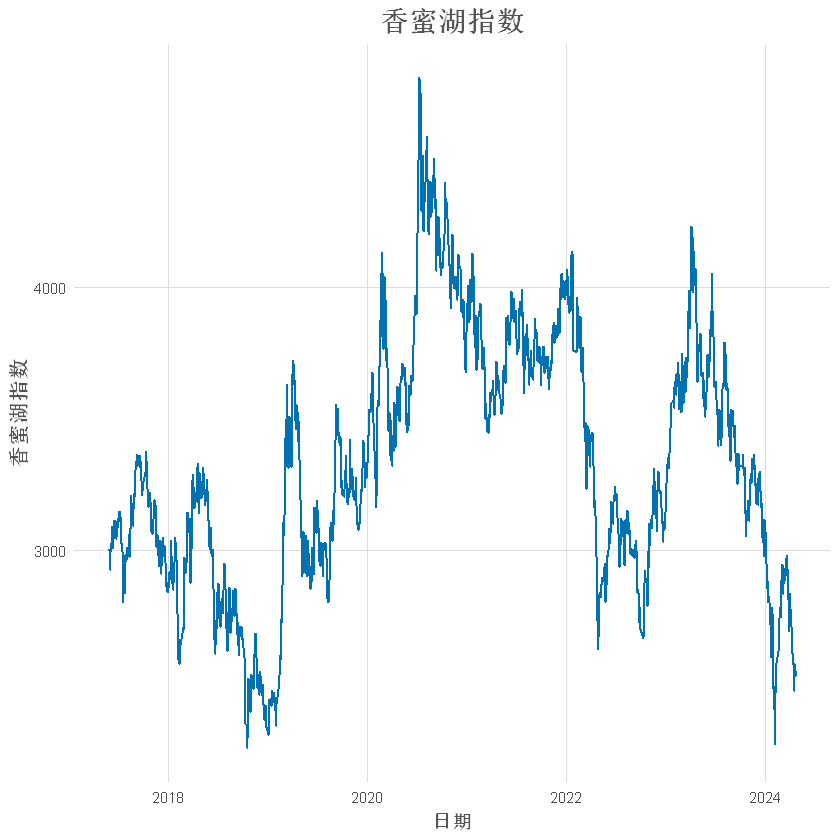

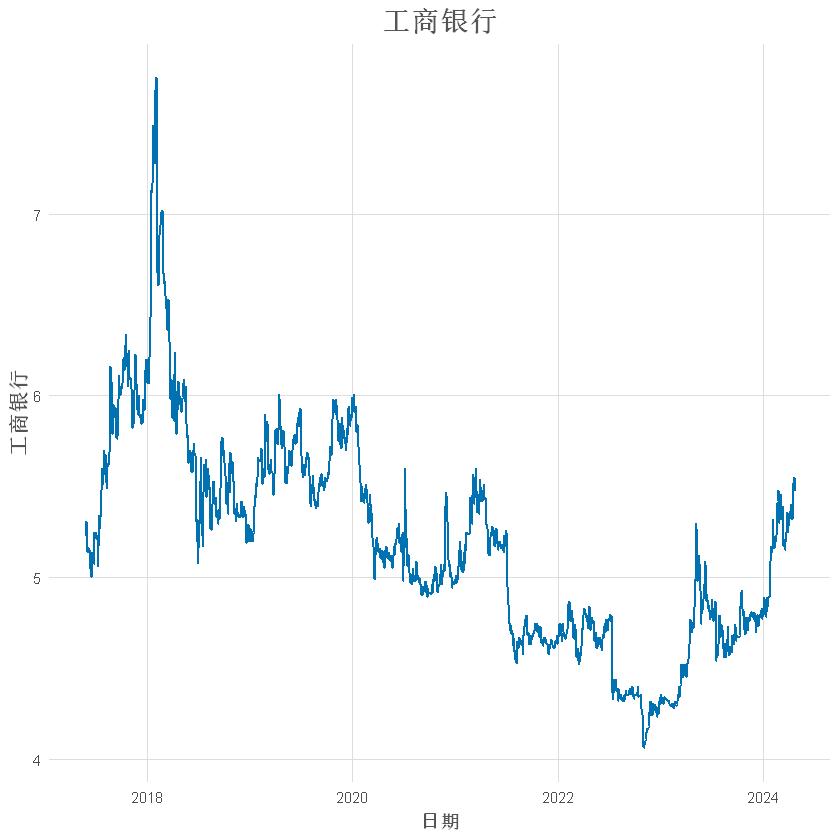

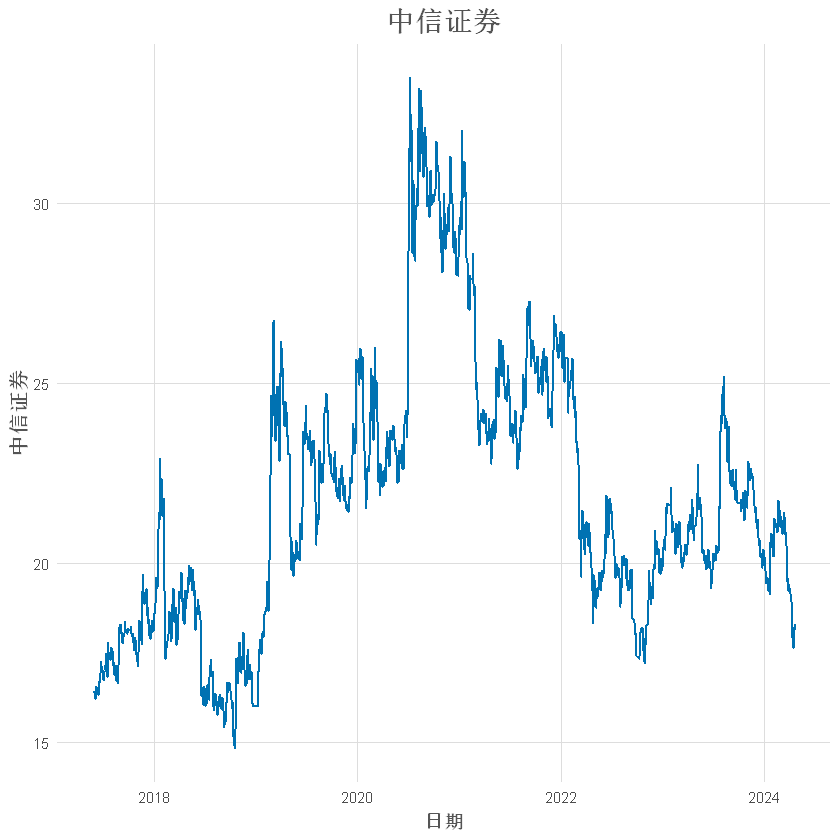

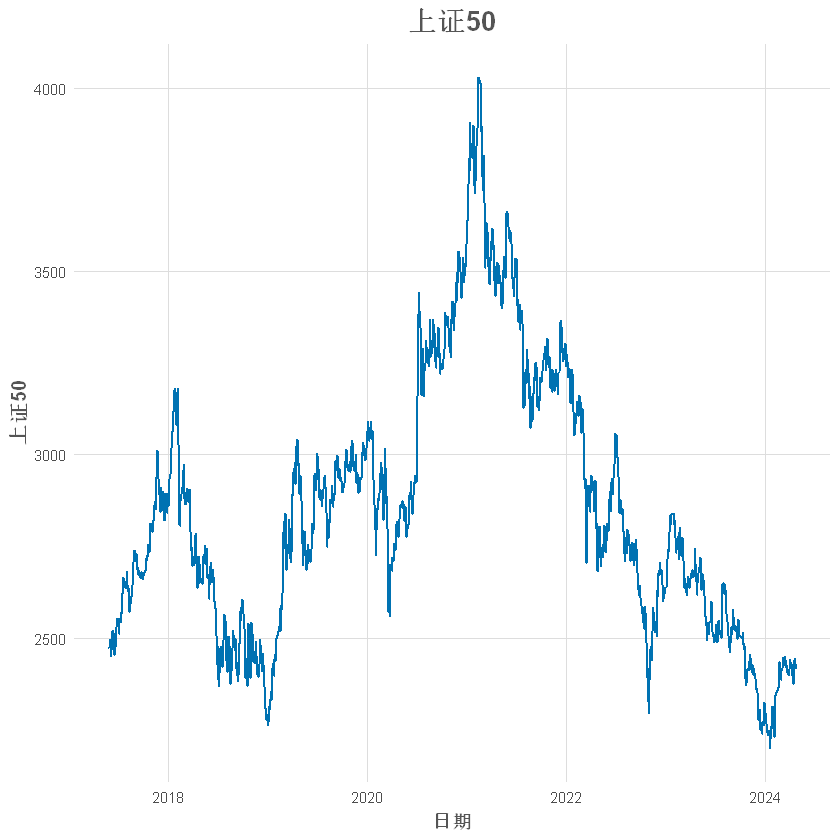

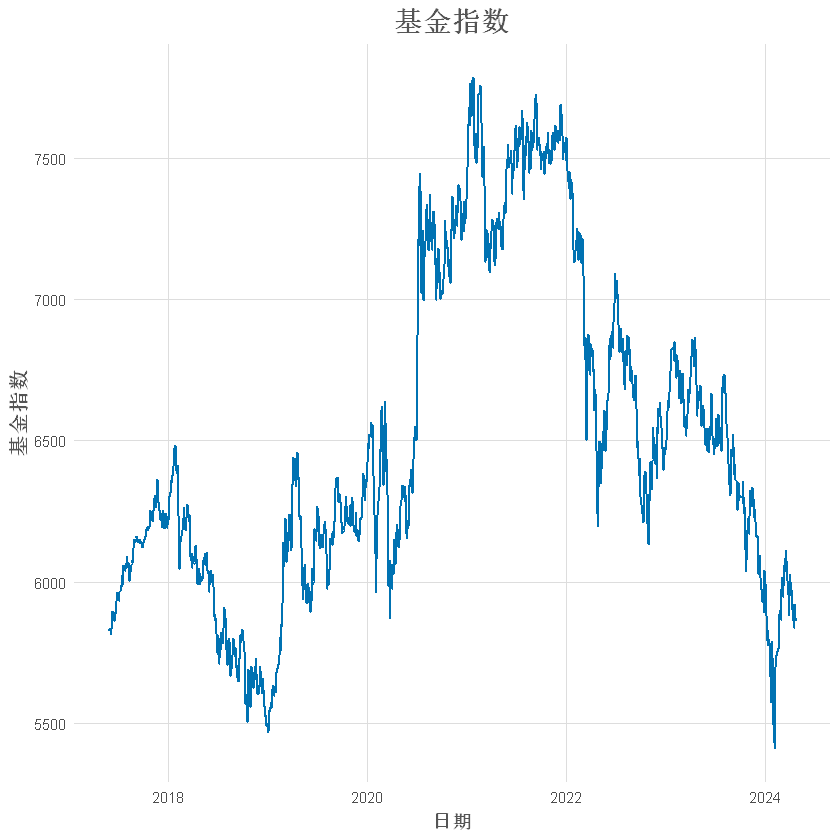

In [5]:

variable_names <- colnames(data)[-which(colnames(data) == "日期")]

for (variable in variable_names) {
  current_data <- data[c("日期", variable)]
  
  p <- ggplot(current_data, aes(x = 日期, y = !!sym(variable))) +
    geom_line(color = "#0072B2", size = 0.8) + 
    labs(
      x = "日期", 
      y = variable, 
      title = paste(variable),
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, color = "#555555", size = 16, face = "bold"),  # 调整标题样式
      axis.title.x = element_text(face = "bold", color = "#555555", size = 12),
      axis.title.y = element_text(face = "bold", color = "#555555", size = 12),
      panel.grid.major = element_line(color = "#DDDDDD"),
      panel.grid.minor = element_blank(),
      legend.position = "none"
    )
  
  print(p)
}


In [6]:
df <- read_excel("C:\\Users\\88464\\Desktop\\ts_data.xlsx")
df$日期 <- as.Date(df$日期, format = "%Y-%m-%d")
# 调整为日期格式
ts_df <- xts(df[-1], order.by = df$日期)
date_st <- index(ts_df)
dim(ts_df)
tail(ts_df)

[1] 1678    5

           香蜜湖指数   工商银行     基金指数     上证50    中信证券
2024-04-16 -4.0291639  0.9182801 -0.549962451 -0.4838379 -0.62199805
2024-04-17  4.2765524  0.5469476 -0.284285204  1.1351721  2.63099419
2024-04-18 -0.3160644  0.3629768  0.249136693  0.2186259  0.60589555
2024-04-19 -1.6792034  0.5420067  0.098898668 -0.5997007 -0.44028690
2024-04-22  0.3443545 -1.2692827 -0.002398464 -0.2401486  0.82395413
2024-04-23  0.5518959  0.3642991 -0.099072532 -0.4551014 -0.05471956

##对数收益率

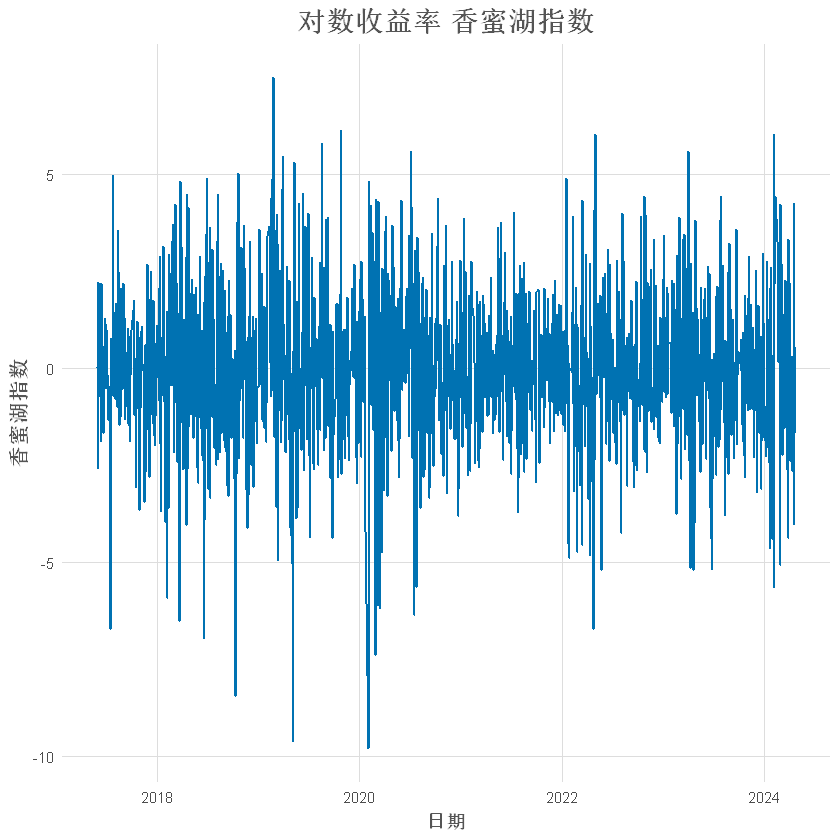

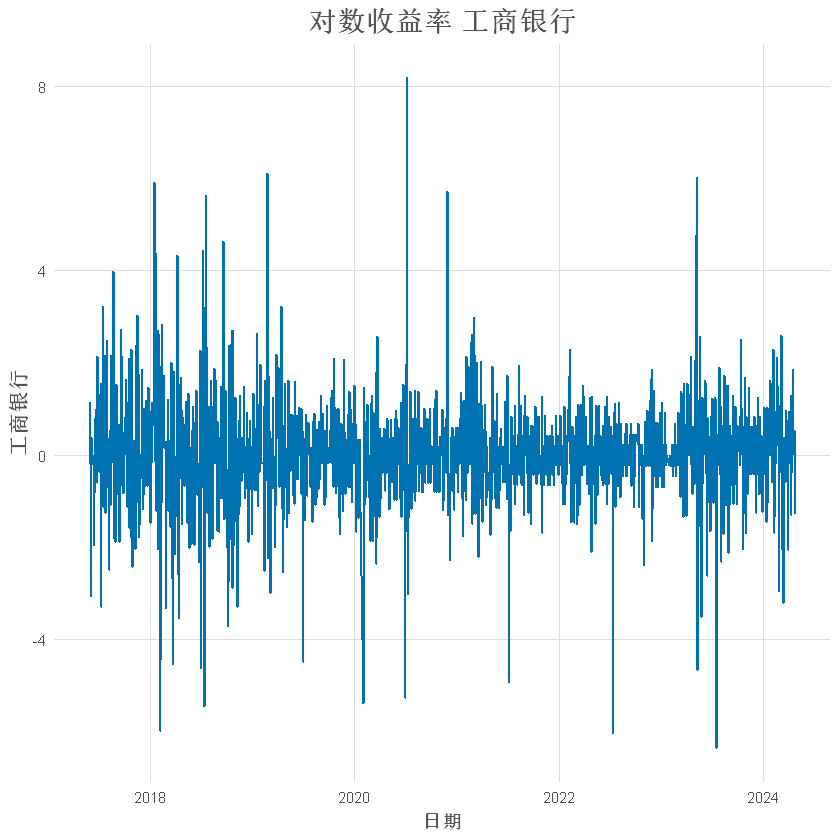

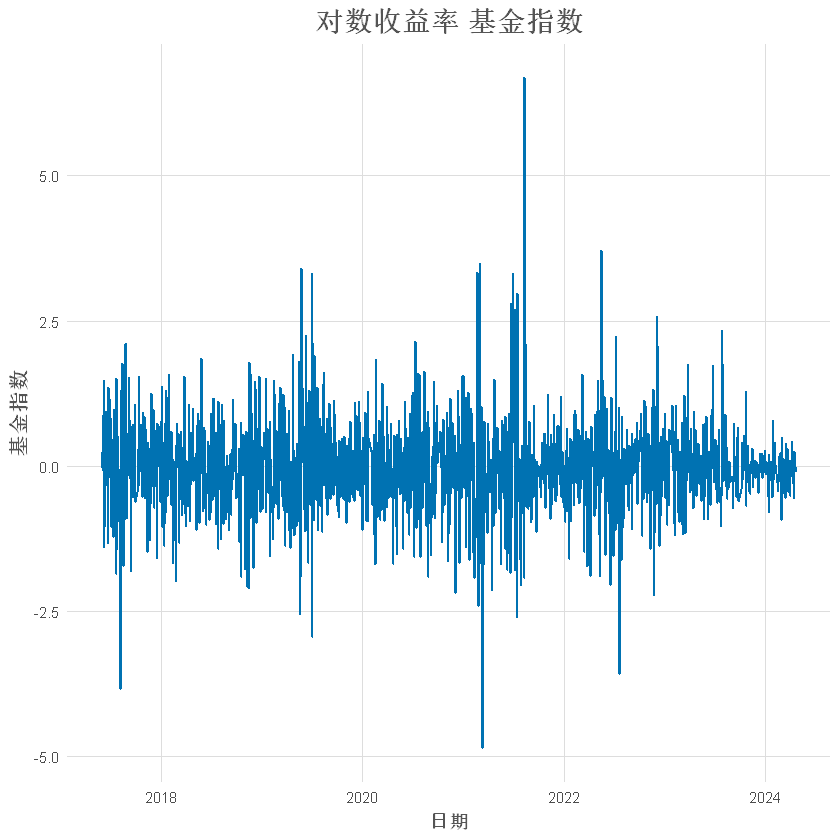

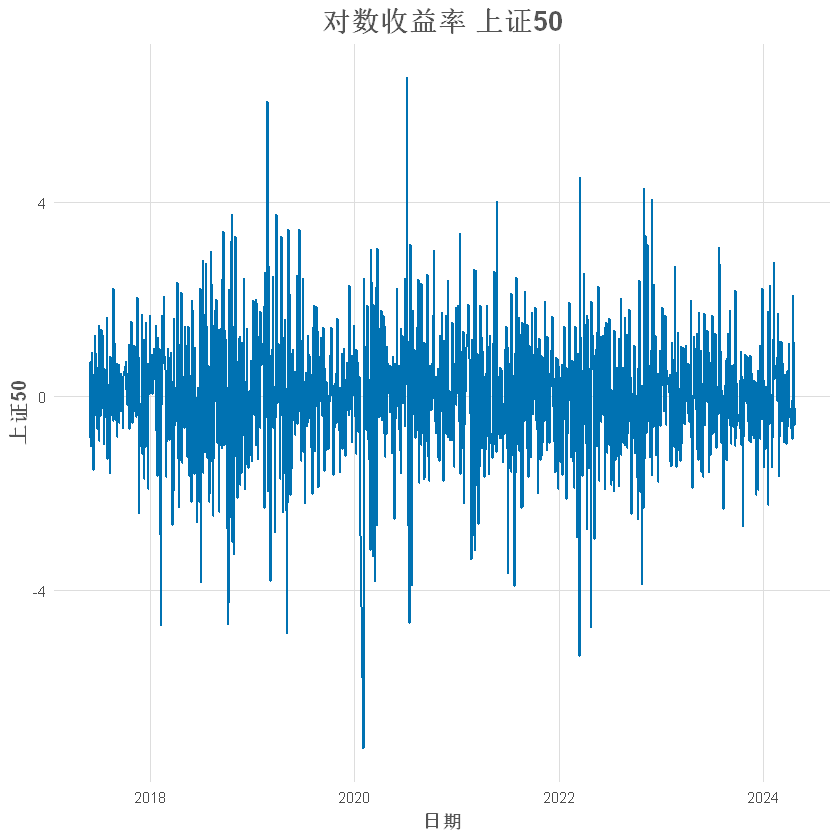

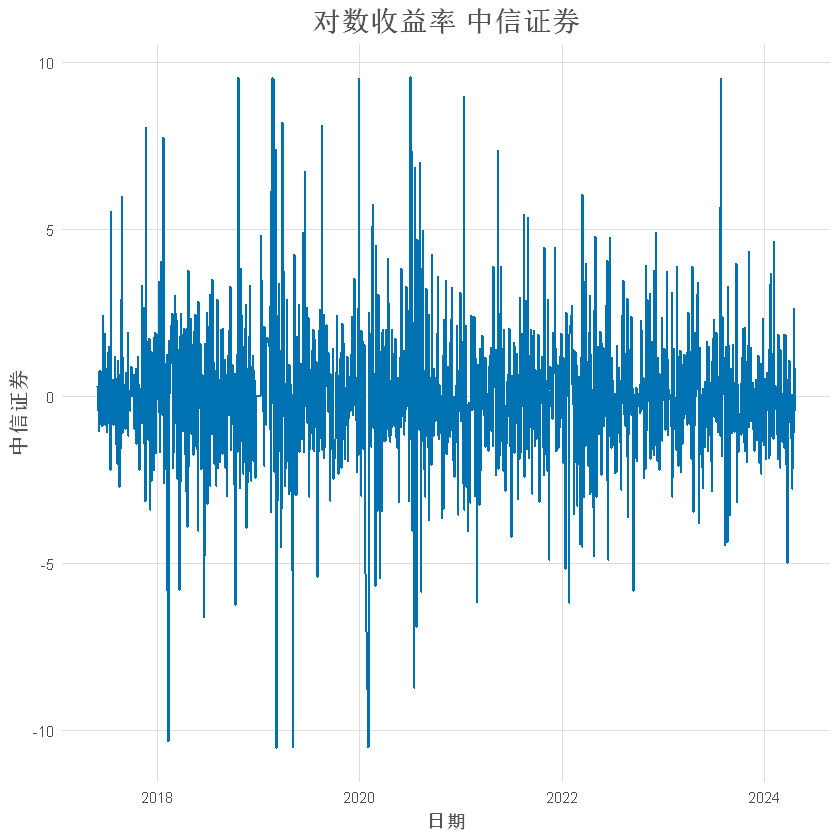

In [7]:
log_data <- colnames(df)[-1]

# 循环遍历每一个变量名
for (variable in log_data) {
  p <- ggplot(df, aes(x = 日期, y = !!sym(variable))) +
    geom_line(color = "#0072B2", size = 0.8) + 
    labs(
      x = "日期", 
      y =  variable, 
      title = paste( '对数收益率',variable)
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, color = "#555555", size = 16, face = "bold"),
      axis.title.x = element_text(face = "bold", color = "#555555", size = 12),
      axis.title.y = element_text(face = "bold", color = "#555555", size = 12),
      panel.grid.major = element_line(color = "#DDDDDD"),
      panel.grid.minor = element_blank(),
      legend.position = "none"
    )
  
  print(p)
}


##时间序列建模前的描述性统计（适合进一步建时间序列模型）

In [8]:

stats <- data.frame(
  Median = apply(ts_df, 2, median, na.rm = TRUE),
  Max = apply(ts_df, 2, max, na.rm = TRUE),
  Min = apply(ts_df, 2, min, na.rm = TRUE),
  StdDev = apply(ts_df, 2, sd, na.rm = TRUE),
  Skewness = apply(ts_df, 2, skewness, na.rm = TRUE),
  Kurtosis = apply(ts_df, 2, kurtosis, na.rm = TRUE)
)
print(stats)


                 Median      Max        Min    StdDev    Skewness Kurtosis
香蜜湖指数 -0.035582761 7.506944  -9.797493 1.9049984 -0.18531481 4.780378
工商银行    0.000000000 8.183002  -6.358073 1.1494780  0.09004365 9.626870
基金指数    0.009672448 6.686416  -4.857354 0.7849274  0.34936379 8.924402
上证50     -0.002884543 6.583431  -7.261678 1.1993421 -0.12020979 6.028800
中信证券   -0.047676076 9.544971 -10.552661 1.9865896  0.37146930 8.233389


In [9]:

results <- lapply(ts_df, function(column) {
  if (is.numeric(column)) {
    list(
      JarqueBera = jarque.bera.test(column),
      ArchTest = ArchTest(column),
      ADFTest = adf.test(column)
    )
  }
})
print(results)


Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"
Warning message in adf.test(column):
"p-value smaller than printed p-value"


$香蜜湖指数
$香蜜湖指数$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 231.22, df = 2, p-value < 2.2e-16


$香蜜湖指数$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 57.625, df = 12, p-value = 6.095e-08


$香蜜湖指数$ADFTest

	Augmented Dickey-Fuller Test

data:  column
Dickey-Fuller = -11.395, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



$工商银行
$工商银行$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 3072.7, df = 2, p-value < 2.2e-16


$工商银行$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 105.43, df = 12, p-value < 2.2e-16


$工商银行$ADFTest

	Augmented Dickey-Fuller Test

data:  column
Dickey-Fuller = -12.126, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary



$基金指数
$基金指数$JarqueBera

	Jarque Bera Test

data:  column
X-squared = 2488.1, df = 2, p-value < 2.2e-16


$基金指数$ArchTest

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  column
Chi-squared = 71.472, df = 12, p

结果解释：JB检验用来测试数据正态性，此处p值远小于常见的显著性水平，拒绝原假设，认为收益率数据不符合正态分布。LM检验用于检测异方差性，即时间序列存在条件异方差性，有强烈的波动率集群效应，有ARCH效应应用GARCH模型建模。ADF检验结果表明所有序列都是平稳的。综合来看能够进一步建立时间序列模型分析。

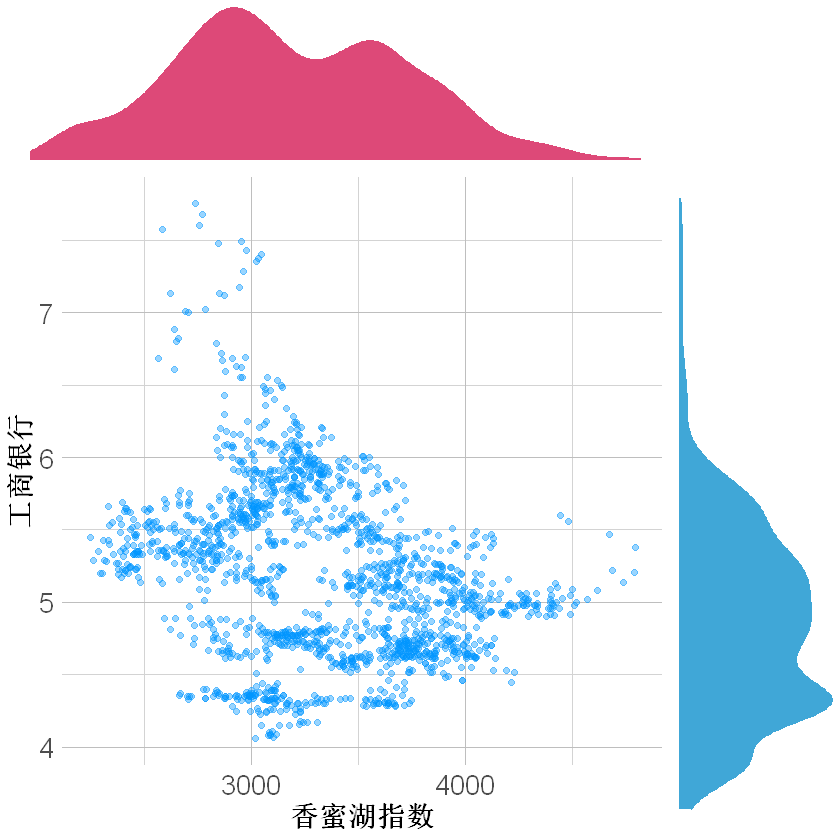

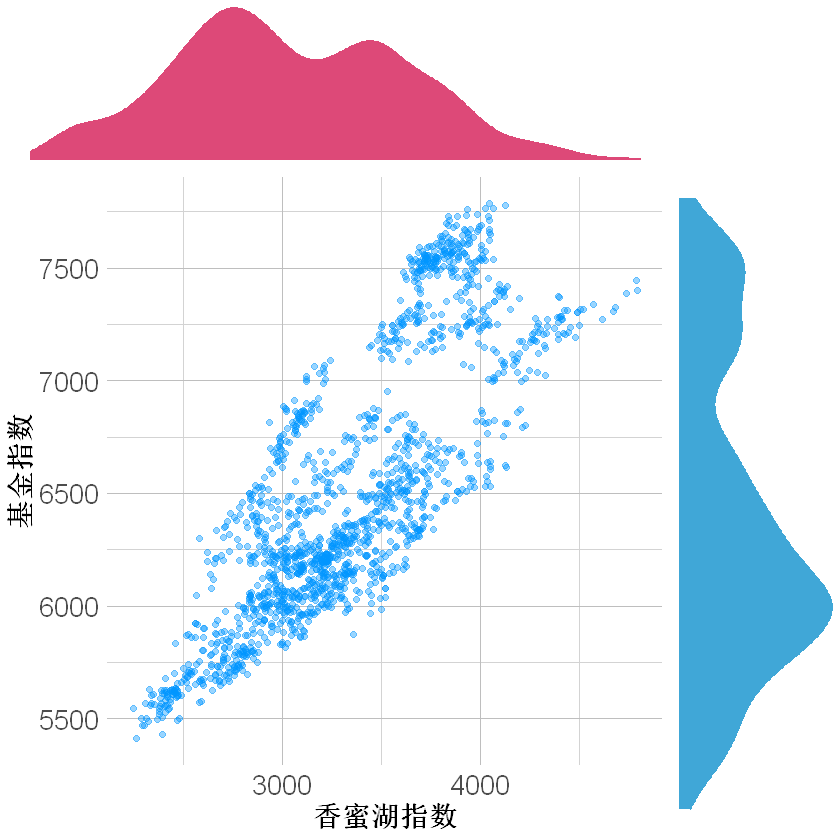

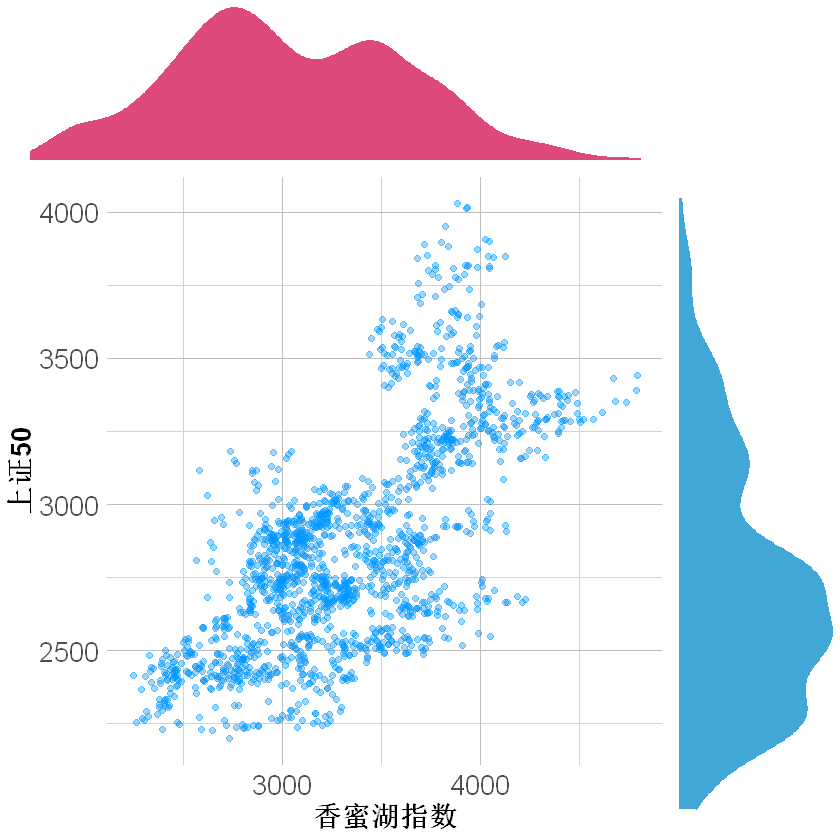

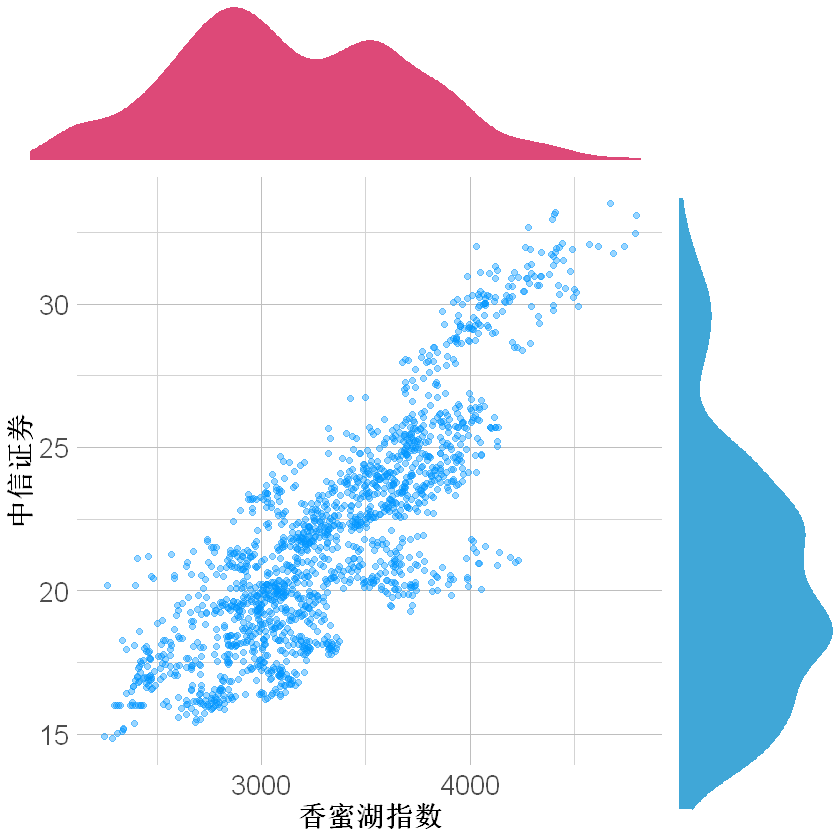

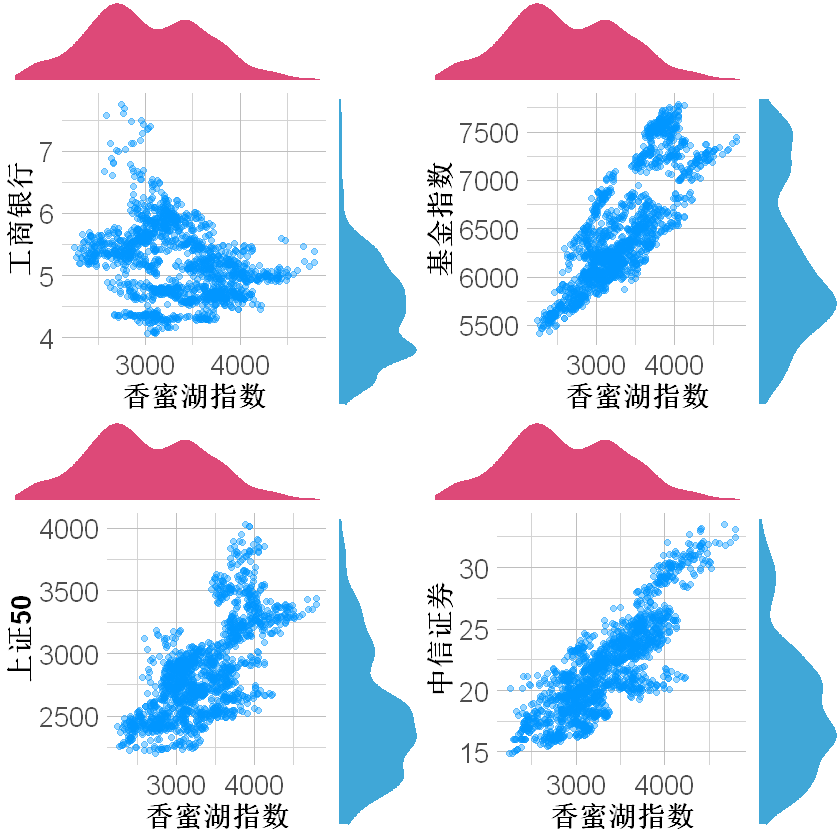

In [10]:
plot_with_marginal_density <- function(data, x_var, y_var) {
  # 使用整洁评估方式处理变量
  x_var_sym <- sym(x_var)
  y_var_sym <- sym(y_var)

  # 主散点图
  main_plot <- ggplot(data, aes(x = !!x_var_sym, y = !!y_var_sym)) +
    geom_point(alpha = 0.4, color = "#0095ff") +
    theme_minimal() +
    theme(panel.grid.major = element_line(color = "gray", linewidth = 0.5),
          panel.grid.minor = element_line(color = "lightgray", linewidth = 0.25),
          text = element_text(size = 16),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 16, face = "bold"),
          plot.title = element_text(size = 16, hjust = 0.5))

  # X变量的密度图
  top_density <- ggplot(data, aes(x = !!x_var_sym)) +
    geom_density(fill = "#dd4978", color = "#dd4978") +
    theme_void()

  # Y变量的密度图
  right_density <- ggplot(data, aes(x = !!y_var_sym)) +
    geom_density(fill = "#40a7d7", color = "#40a7d7") +
    theme_void() +
    coord_flip()

  # 组合图形
  combined_plot <- grid.arrange(
    top_density, nullGrob(),
    main_plot, right_density,
    ncol = 2, nrow = 2,
    widths = c(4, 1), heights = c(1, 4),
    layout_matrix = matrix(c(1, 2, 3, 4), 2, 2, byrow = TRUE)
  )
  
  return(combined_plot)
}
# 应用函数绘制图形
variables <- c('工商银行', '基金指数', '上证50', '中信证券')
plots <- lapply(variables, function(var) {
  plot_with_marginal_density(data, "香蜜湖指数", var)
})

# 显示图形
do.call(grid.arrange, c(plots, ncol = 2))

粗略可以看出香蜜湖指数和证券基金股票和银行市场都有明显的正相关关系 图中还可以直观看出上尾下尾存在非线性关系 应该用非线性模型来研究风险溢出

##对比arma（1，2）-garch（1，1），arma（1，2）-egarch（1，1）和三种分布的LLF和AIC

In [55]:
#ARMA(1,2)-egarch(1,1) model（sstd）
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f1 <- function(x) {ugarchfit(uspec, data = x)}
fit <- apply(ts_df,2, f1)

In [56]:
fit

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.023925    0.021797   -1.0976 0.272364
ar1    -0.402263    0.054178   -7.4249 0.000000
ma1     0.385777    0.054390    7.0928 0.000000
ma2     0.022511    0.015336    1.4679 0.142142
omega   0.047997    0.004089   11.7378 0.000000
alpha1 -0.039948    0.015851   -2.5202 0.011729
beta1   0.962088    0.000120 8015.9724 0.000000
gamma1  0.145880    0.003505   41.6248 0.000000
skew    1.018411    0.031796   32.0293 0.000000
shape   6.603911    1.072243    6.1590 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.023925    0.011298   -2.1176 0.034212
ar1    -0.402263    0.010630  -37.8

In [13]:
#ARMA(1,2)-egarch(1,1) model（std）
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
distribution.model = "std")
#用刚刚定义的模型拟合各列数据
f1_1 <- function(x) {ugarchfit(uspec, data = x)}
fit_1 <- apply(ts_df,2, f1_1)

In [14]:
fit_1

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu     -0.031767    0.041900    -0.75815 0.448362
ar1    -0.407631    0.082958    -4.91369 0.000001
ma1     0.390623    0.083146     4.69807 0.000003
ma2     0.021771    0.024662     0.88278 0.377357
omega   0.048857    0.004228    11.55532 0.000000
alpha1 -0.041005    0.016080    -2.55014 0.010768
beta1   0.961549    0.000063 15375.68412 0.000000
gamma1  0.147376    0.003676    40.09207 0.000000
shape   6.648771    1.084799     6.12904 0.000000

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu     -0.031767    0.042507    -0.74733 0.454866
ar1    -0.407631    0.014142   -28.82421 0.000000
ma1     0.

In [15]:
#ARMA(1,2)-egarch(1,1) model（norm）
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
distribution.model = "norm")
#用刚刚定义的模型拟合各列数据
f1_2 <- function(x) {ugarchfit(uspec, data = x)}
fit_2 <- apply(ts_df,2, f1_2)

In [16]:
fit_2

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.029143    0.045243 -0.64414 0.519482
ar1    -0.259327    0.145561 -1.78157 0.074819
ma1     0.259971    0.145879  1.78209 0.074734
ma2     0.036712    0.025750  1.42572 0.153949
omega   0.077743    0.035582  2.18490 0.028896
alpha1 -0.058137    0.022753 -2.55511 0.010615
beta1   0.942599    0.027963 33.70849 0.000000
gamma1  0.167623    0.030533  5.48987 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.029143    0.049661 -0.58685 0.557305
ar1    -0.259327    0.034599 -7.49530 0.000000
ma1     0.259971    0.036654  7.09254 0.000000
ma2     0.036712    0.024173  1.51873 0.128831
o

In [17]:
#ARMA(1,2)-garch(1,1) model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f2 <- function(x) {ugarchfit(uspec, data = x)}
fit2 <- apply(ts_df,2, f2)

In [18]:
fit2


$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.007353    0.043471 -0.16915 0.865681
ar1    -0.376335    0.412649 -0.91200 0.361771
ma1     0.359781    0.412024  0.87320 0.382552
ma2     0.024589    0.027864  0.88248 0.377520
omega   0.104244    0.042514  2.45198 0.014207
alpha1  0.054203    0.012409  4.36804 0.000013
beta1   0.918944    0.019527 47.06112 0.000000
skew    1.023204    0.033488 30.55452 0.000000
shape   6.400032    1.016258  6.29764 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.007353    0.040730 -0.18053  0.85673
ar1    -0.376335    0.258108 -1.45805  0.14483
ma1     0.359781    0.257364  1.39795  0.16213
m

In [19]:
#ARMA(1,2)-garch(1,1) model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
distribution.model = "std")
#用刚刚定义的模型拟合各列数据
f2_1 <- function(x) {ugarchfit(uspec, data = x)}
fit2_1 <- apply(ts_df,2, f2_1)

In [20]:
fit2_1

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.017396    0.040979 -0.42452 0.671187
ar1    -0.388311    0.426515 -0.91043 0.362598
ma1     0.370761    0.425958  0.87042 0.384073
ma2     0.022650    0.028117  0.80557 0.420488
omega   0.105095    0.042701  2.46115 0.013849
alpha1  0.054725    0.012440  4.39928 0.000011
beta1   0.918112    0.019598 46.84718 0.000000
shape   6.465637    1.033569  6.25564 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.017396    0.037669 -0.46182 0.644210
ar1    -0.388311    0.267455 -1.45187 0.146537
ma1     0.370761    0.266840  1.38945 0.164696
ma2     0.022650    0.024449  0.92645 0.354213
om

In [21]:
#ARMA(1,2)-garch(1,1) model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
distribution.model = "norm")
#用刚刚定义的模型拟合各列数据
f2_2 <- function(x) {ugarchfit(uspec, data = x)}
fit2_2 <- apply(ts_df,2, f2_2)

In [22]:
fit2_2

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.004364    0.044629 -0.097787 0.922102
ar1    -0.188559    0.533641 -0.353344 0.723830
ma1     0.192240    0.532883  0.360756 0.718282
ma2     0.034048    0.026406  1.289406 0.197257
omega   0.144818    0.048760  2.970025 0.002978
alpha1  0.060411    0.012718  4.750165 0.000002
beta1   0.900264    0.022388 40.212173 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.004364    0.040877 -0.10676 0.914976
ar1    -0.188559    0.382919 -0.49243 0.622418
ma1     0.192240    0.382741  0.50227 0.615475
ma2     0.034048    0.024582  1.38506 0.166033
omega   0.144818    0.058005  2.49666 0.

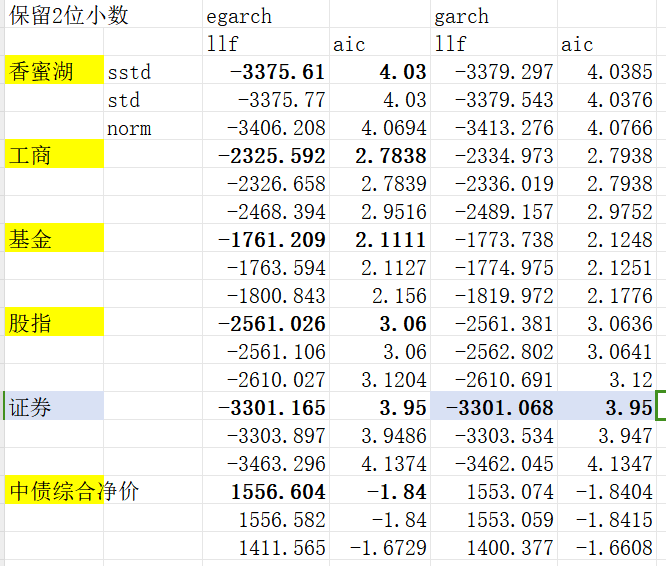

综合考虑最终选择了ARMA（1，2）-EGARCH（1，1）模型建立边缘分布。整理一下模型中参数估计表格。

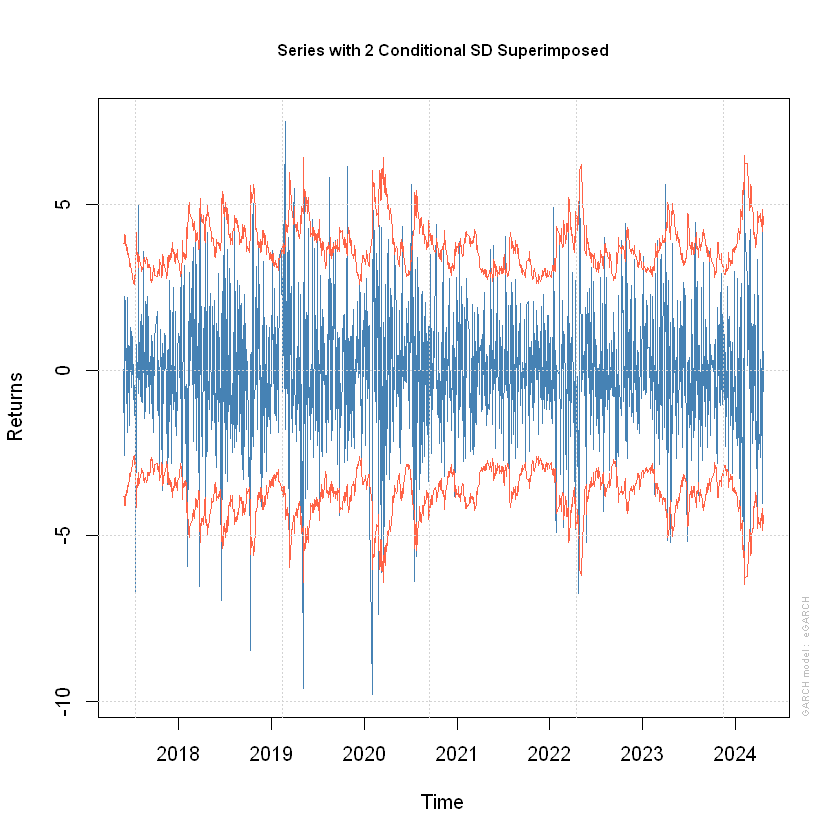

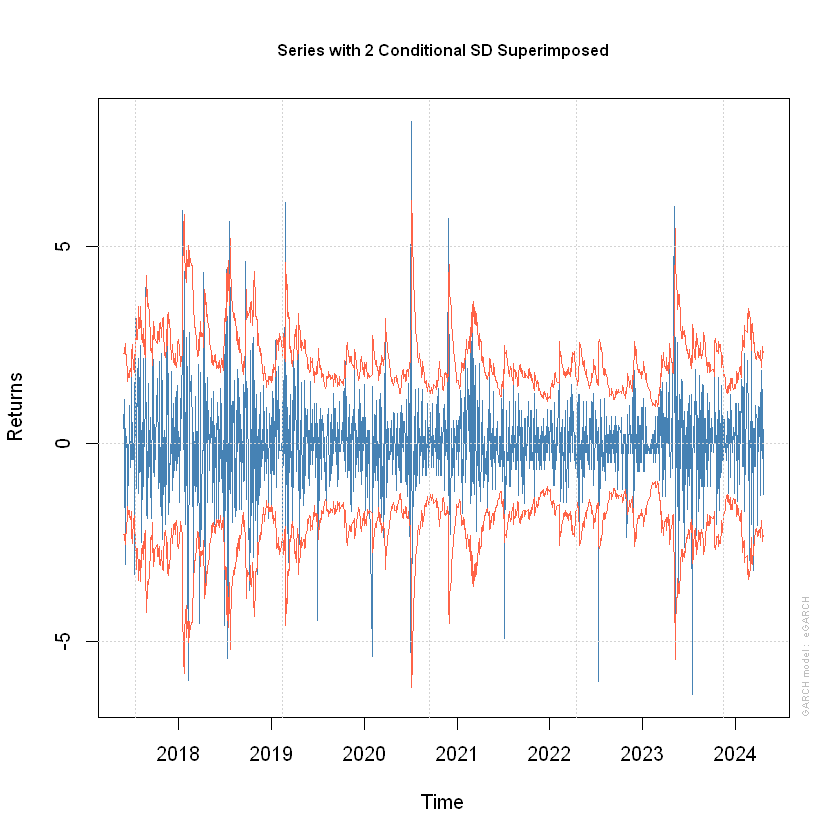

In [23]:
#模型拟合图像(可以都plot一下）)
plot(fit$香蜜湖指数,which=1)
plot(fit$工商银行,which=1)

提取模型残差并标准化

In [24]:
#提取残差
fintech_resi <- residuals(fit$香蜜湖指数)
index(fintech_resi) <- date_st

bank_resi <- residuals(fit$工商银行)
index(bank_resi) <- date_st

fund_resi <- residuals(fit$基金指数)
index(fund_resi) <- date_st

stock_resi <- residuals(fit$上证50)
index(stock_resi) <- date_st

security_resi <- residuals(fit$中信证券)
index(security_resi) <- date_st

运行下段代码前记得重新运行一下fit的代码（之后的操作都是基于fit的模型，和fit1等无关）

In [97]:
#ARMA(1,2)-egarch(1,1) model（sstd）
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f1 <- function(x) {ugarchfit(uspec, data = x)}
fit <- apply(ts_df,2, f1)

$香蜜湖指数

*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.023925    0.021797   -1.0976 0.272364
ar1    -0.402263    0.054178   -7.4249 0.000000
ma1     0.385777    0.054390    7.0928 0.000000
ma2     0.022511    0.015336    1.4679 0.142142
omega   0.047997    0.004089   11.7378 0.000000
alpha1 -0.039948    0.015851   -2.5202 0.011729
beta1   0.962088    0.000120 8015.9724 0.000000
gamma1  0.145880    0.003505   41.6248 0.000000
skew    1.018411    0.031796   32.0293 0.000000
shape   6.603911    1.072243    6.1590 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.023925    0.011298   -2.1176 0.034212
ar1    -0.402263    0.010630  -37.8

In [80]:
#香蜜湖指数进一步处理（rrss第一列残差 第二列条件标准差 第三列标准化残差）
spec_fintech <- uspec
setfixed(spec_fintech) <- as.list(coef(fit$香蜜湖指数))
filt_fintech <- ugarchfilter(spec_fintech, ts_df$香蜜湖指数)
rrss <- cbind(fintech_resi,sigma(filt_fintech),fintech_resi/sigma(filt_fintech))
ssss <- cbind(ts_df$香蜜湖指数,fitted(filt_fintech),fintech_resi,sigma(filt_fintech),fintech_resi/sigma(filt_fintech))
#把标准化残差重命名
fintech_res <- fintech_resi/sigma(filt_fintech)

In [152]:
#检验香蜜湖残差是否为白噪声
Box.test(fintech_res,lag = 6, type = "Ljung-Box")
Box.test(fintech_res,lag = 12, type = "Ljung-Box")
Box.test(fintech_res,lag = 20, type = "Ljung-Box")
#残差的ARCH检验
ArchTest(fintech_res, lags = 6)
ArchTest(fintech_res, lags = 12)
ArchTest(fintech_res, lags = 20)


	Box-Ljung test

data:  fintech_res
X-squared = 6.9838, df = 6, p-value = 0.3223



	Box-Ljung test

data:  fintech_res
X-squared = 10.194, df = 12, p-value = 0.5989



	Box-Ljung test

data:  fintech_res
X-squared = 19.467, df = 20, p-value = 0.4917



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fintech_res
Chi-squared = 1.7595, df = 6, p-value = 0.9404



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fintech_res
Chi-squared = 7.6421, df = 12, p-value = 0.8124



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fintech_res
Chi-squared = 8.4657, df = 20, p-value = 0.9883


In [84]:
#银行进一步处理（rrss1第一列残差 第二列条件标准差 第三列标准化残差）
spec_bank <- uspec
setfixed(spec_bank) <- as.list(coef(fit$工商银行))
filt_bank <- ugarchfilter(spec_bank, ts_df$工商银行)
rrss1 <- cbind(bank_resi,sigma(filt_bank),bank_resi/sigma(filt_bank))
ssss1 <- cbind(ts_df$工商银行,fitted(filt_bank),bank_resi,sigma(filt_bank),bank_resi/sigma(filt_bank))
#把标准化残差重命名
bank_res <- bank_resi/sigma(filt_bank)

In [153]:
Box.test(bank_res,lag = 6, type = "Ljung-Box")
Box.test(bank_res,lag = 12, type = "Ljung-Box")
Box.test(bank_res,lag = 20, type = "Ljung-Box")

ArchTest(bank_res, lags = 6)
ArchTest(bank_res, lags = 12)
ArchTest(bank_res, lags = 20)


	Box-Ljung test

data:  bank_res
X-squared = 9.0751, df = 6, p-value = 0.1694



	Box-Ljung test

data:  bank_res
X-squared = 13.632, df = 12, p-value = 0.3248



	Box-Ljung test

data:  bank_res
X-squared = 17.612, df = 20, p-value = 0.6129



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  bank_res
Chi-squared = 4.7543, df = 6, p-value = 0.5757



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  bank_res
Chi-squared = 7.3395, df = 12, p-value = 0.8344



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  bank_res
Chi-squared = 10.057, df = 20, p-value = 0.9671


In [86]:
#基金进一步处理（rrss2第一列残差 第二列条件标准差 第三列标准化残差）
spec_fund <- uspec
setfixed(spec_fund) <- as.list(coef(fit$基金指数))
filt_fund <- ugarchfilter(spec_fund, ts_df$基金指数)
rrss2 <- cbind(fund_resi,sigma(filt_fund),fund_resi/sigma(filt_fund))
ssss2 <- cbind(ts_df$基金指数,fitted(filt_fund),fund_resi,sigma(filt_fund),fund_resi/sigma(filt_fund))
#把标准化残差重命名
fund_res <- fund_resi/sigma(filt_fund)

In [154]:
Box.test(fund_res,lag = 6, type = "Ljung-Box")
Box.test(fund_res,lag = 12, type = "Ljung-Box")
Box.test(fund_res,lag = 20, type = "Ljung-Box")

ArchTest(fund_res, lags = 6)
ArchTest(fund_res, lags = 12)
ArchTest(fund_res, lags = 20)


	Box-Ljung test

data:  fund_res
X-squared = 13.149, df = 6, p-value = 0.04072



	Box-Ljung test

data:  fund_res
X-squared = 16.653, df = 12, p-value = 0.1631



	Box-Ljung test

data:  fund_res
X-squared = 25.341, df = 20, p-value = 0.1887



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fund_res
Chi-squared = 2.9817, df = 6, p-value = 0.8111



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fund_res
Chi-squared = 14.972, df = 12, p-value = 0.243



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  fund_res
Chi-squared = 19.64, df = 20, p-value = 0.4807


In [88]:
#股票进一步处理（rrss3第一列残差 第二列条件标准差 第三列标准化残差）
spec_stock <- uspec
setfixed(spec_stock) <- as.list(coef(fit$上证50))
filt_stock <- ugarchfilter(spec_stock, ts_df$上证50)
rrss3 <- cbind(stock_resi,sigma(filt_stock),stock_resi/sigma(filt_stock))
ssss3 <- cbind(ts_df$上证50,fitted(filt_stock),stock_resi,sigma(filt_stock),stock_resi/sigma(filt_stock))
#把标准化残差重命名
stock_res <- stock_resi/sigma(filt_stock)

In [155]:
Box.test(stock_res,lag = 6, type = "Ljung-Box")
Box.test(stock_res,lag = 12, type = "Ljung-Box")
Box.test(stock_res,lag = 20, type = "Ljung-Box")

ArchTest(stock_res, lags = 6)
ArchTest(stock_res, lags = 12)
ArchTest(stock_res, lags = 20)


	Box-Ljung test

data:  stock_res
X-squared = 12.42, df = 6, p-value = 0.05324



	Box-Ljung test

data:  stock_res
X-squared = 15.657, df = 12, p-value = 0.2074



	Box-Ljung test

data:  stock_res
X-squared = 22.341, df = 20, p-value = 0.3223



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  stock_res
Chi-squared = 7.8171, df = 6, p-value = 0.2518



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  stock_res
Chi-squared = 13.022, df = 12, p-value = 0.3675



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  stock_res
Chi-squared = 17.153, df = 20, p-value = 0.643


In [90]:
#证券进一步处理（rrss4第一列残差 第二列条件标准差 第三列标准化残差）
spec_security <- uspec
setfixed(spec_security) <- as.list(coef(fit$中信证券))
filt_security <- ugarchfilter(spec_security, ts_df$中信证券)
rrss4 <- cbind(security_resi,sigma(filt_security),security_resi/sigma(filt_security))
ssss4 <- cbind(ts_df$中信证券,fitted(filt_security),security_resi,sigma(filt_security),security_resi/sigma(filt_security))
#把标准化残差重命名
security_res <- security_resi/sigma(filt_security)

In [156]:
Box.test(security_res,lag = 6, type = "Ljung-Box")
Box.test(security_res,lag = 12, type = "Ljung-Box")
Box.test(security_res,lag = 20, type = "Ljung-Box")

ArchTest(security_res, lags = 6)
ArchTest(security_res, lags = 12)
ArchTest(security_res, lags = 20)


	Box-Ljung test

data:  security_res
X-squared = 8.418, df = 6, p-value = 0.209



	Box-Ljung test

data:  security_res
X-squared = 18.474, df = 12, p-value = 0.102



	Box-Ljung test

data:  security_res
X-squared = 24.871, df = 20, p-value = 0.2064



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  security_res
Chi-squared = 8.18, df = 6, p-value = 0.2252



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  security_res
Chi-squared = 14.15, df = 12, p-value = 0.2912



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  security_res
Chi-squared = 18.733, df = 20, p-value = 0.5392


EVT：形状参数小于0，尺度参数大于0才有必要用evt？

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.811639 1.779546 
Weights: 0.032777 0.929678 0.037545 

Parameters: 
    loc1   scale1   shape1     mean       sd     loc2   scale2   shape2 
1.811639 0.637257 0.081026 0.008827 0.878516 1.779546 0.650171 0.052678 

Log-likelihood: -2342.483,  Average log-likelihood: -1.396


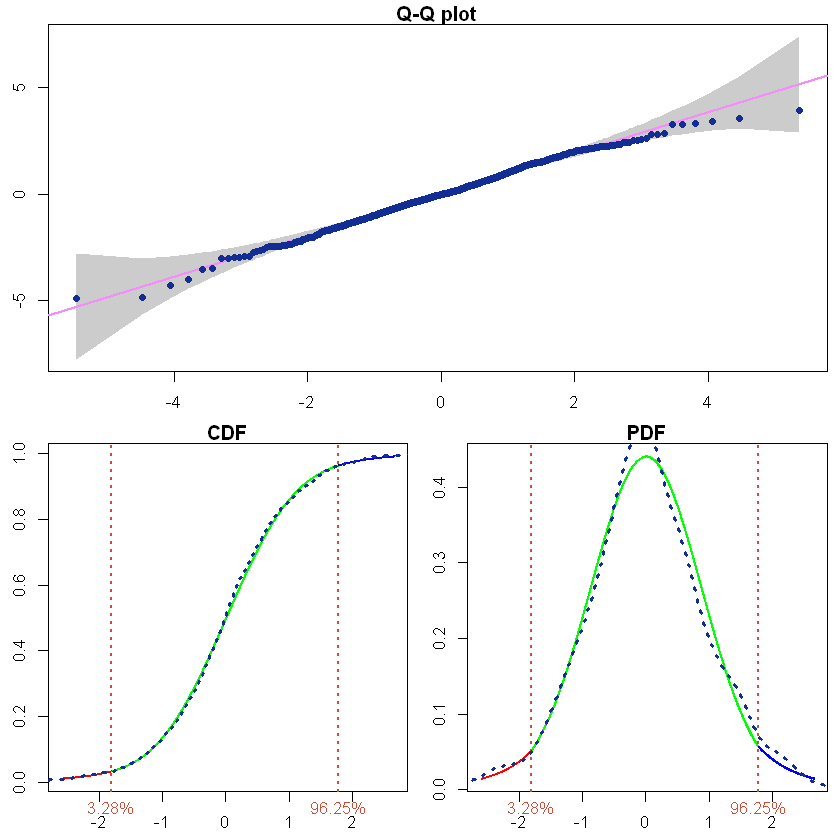

In [92]:
evt_fintech<-GNG_fit(fintech_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_fintech
plot(evt_fintech)

In [93]:
#下尾形状参数0.081，尺度参数0.6373；上尾形状参数0.0527，尺度参数：0.6502
distribution(evt_fintech)

Composite distribution with: 
 
  Trafo       Distribution                                   Parameters Weight
1  -X   Generalized Pareto loc = 1.8116, scale = 0.6373, shape = 0.081  0.0328
2 none        Normal                mean = 0.0088, sd = 0.8785          0.9297
3 none  Generalized Pareto loc = 1.7795, scale = 0.6502, shape = 0.0527 0.0375
        Truncation
1  (-Inf,-1.8116) 
2 [-1.8116,1.7795)
3   [1.7795,Inf)  

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.873546 1.442252 
Weights: 0.02503 0.919547 0.055423 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.873546  0.704815  0.360841 -0.017674  0.815716  1.442252  0.581914  0.217414 

Log-likelihood: -2260.472,  Average log-likelihood: -1.3471


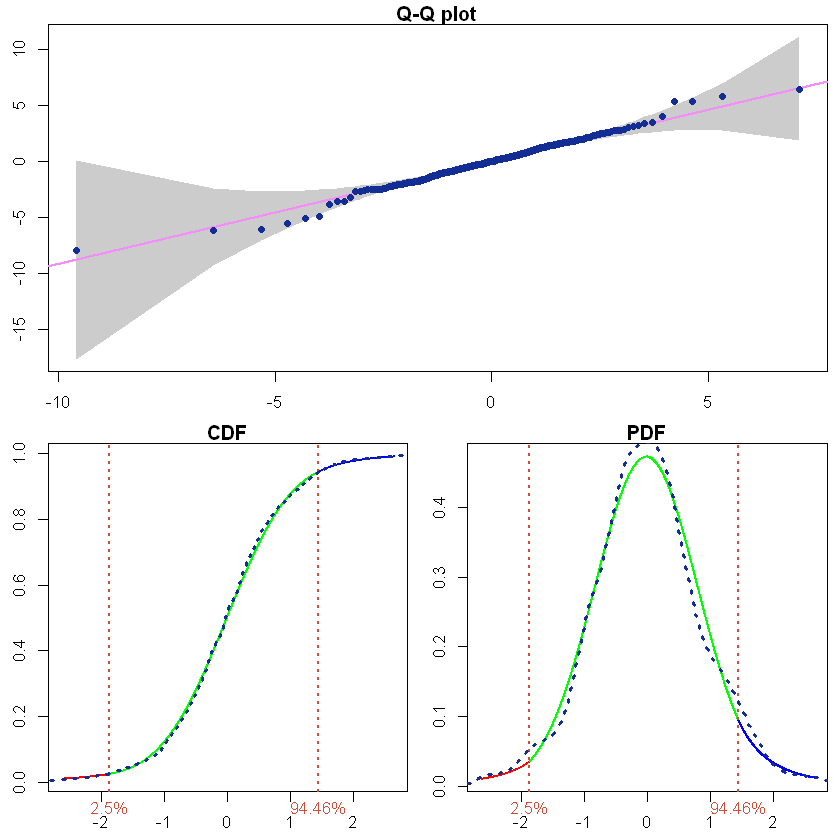

In [94]:
evt_bank <- GNG_fit(bank_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_bank
plot(evt_bank)

In [99]:
#下尾形状参数0.3608，尺度参数0.7048；上尾形状参数0.2174 尺度参数0.5819
distribution(evt_bank)

Composite distribution with: 
 
  Trafo       Distribution                                   Parameters Weight
1  -X   Generalized Pareto loc = 1.8735, scale = 0.7048, shape = 0.3608 0.0250
2 none        Normal               mean = -0.0177, sd = 0.8157          0.9195
3 none  Generalized Pareto loc = 1.4423, scale = 0.5819, shape = 0.2174 0.0554
        Truncation
1  (-Inf,-1.8735) 
2 [-1.8735,1.4423)
3   [1.4423,Inf)  

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.65222 1.655386 
Weights: 0.050656 0.90584 0.043504 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.652220  0.877112 -0.328292  0.046211  0.836355  1.655386  0.609975  0.000526 

Log-likelihood: -2319.929,  Average log-likelihood: -1.3826


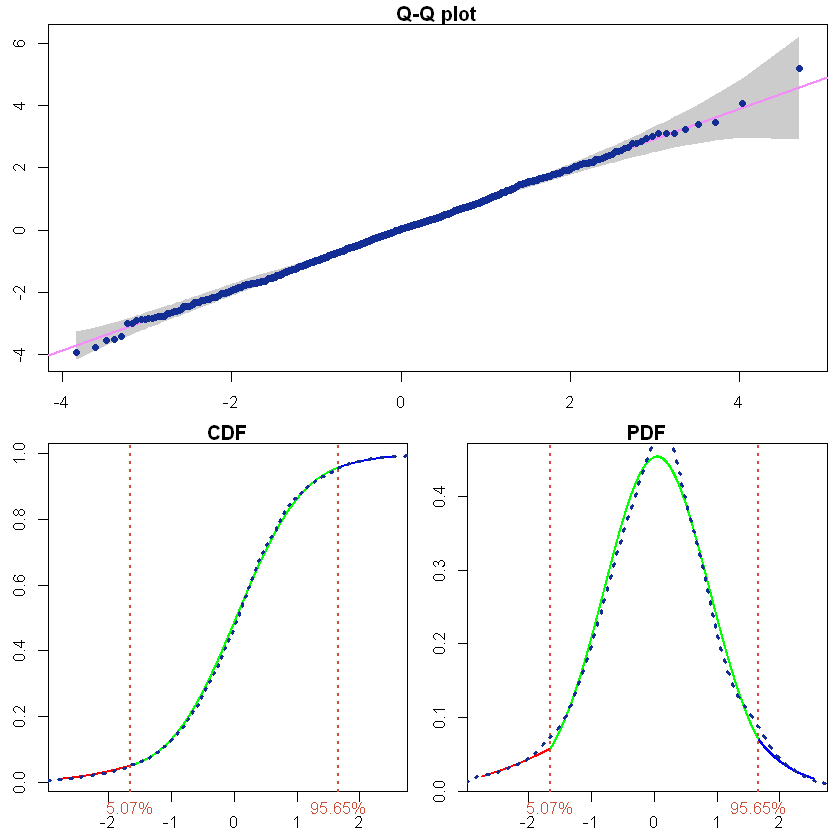

In [100]:
evt_fund <- GNG_fit(fund_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_fund
plot(evt_fund)

In [102]:
#下尾形状参数-0.3283 尺度参数0.8771；上尾形状参数5e-04 尺度参数0.61
distribution(evt_fund)

Composite distribution with: 
 
  Trafo       Distribution                                    Parameters Weight
1  -X   Generalized Pareto loc = 1.6522, scale = 0.8771, shape = -0.3283 0.0507
2 none        Normal                mean = 0.0462, sd = 0.8364           0.9058
3 none  Generalized Pareto   loc = 1.6554, scale = 0.61, shape = 5e-04   0.0435
        Truncation
1  (-Inf,-1.6522) 
2 [-1.6522,1.6554)
3   [1.6554,Inf)  

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.951037 1.333551 
Weights: 0.026818 0.896901 0.076281 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.951037  0.830006 -0.055208 -0.023142  0.837900  1.333551  0.620578  0.001487 

Log-likelihood: -2313.42,  Average log-likelihood: -1.3787


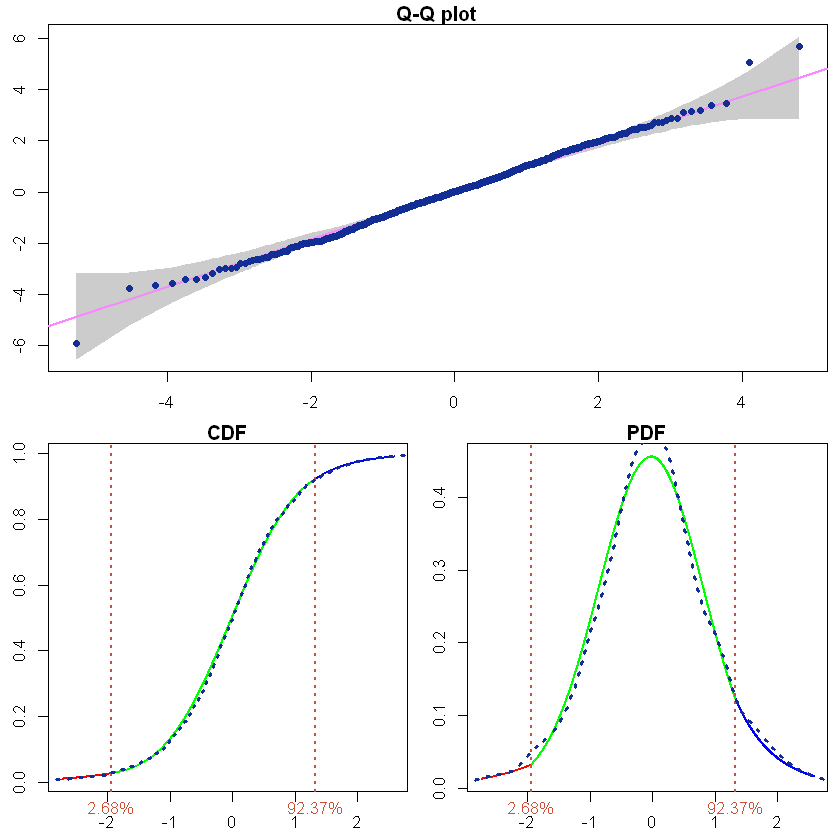

In [103]:
evt_stock <- GNG_fit(stock_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_stock
plot(evt_stock)

In [106]:
# 下尾形状参数-0.0552尺度参数0.83，上尾形状参数0.0015尺度参数0.6206
distribution(evt_stock)

Composite distribution with: 
 
  Trafo       Distribution                                   Parameters Weight
1  -X   Generalized Pareto  loc = 1.951, scale = 0.83, shape = -0.0552  0.0268
2 none        Normal               mean = -0.0231, sd = 0.8379          0.8969
3 none  Generalized Pareto loc = 1.3336, scale = 0.6206, shape = 0.0015 0.0763
       Truncation
1  (-Inf,-1.951) 
2 [-1.951,1.3336)
3  [1.3336,Inf)  

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.357658 1.212936 
Weights: 0.04112 0.892729 0.06615 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.357658  0.689186  0.004655 -0.043966  0.610341  1.212936  0.911413 -0.061308 

Log-likelihood: -2018.806,  Average log-likelihood: -1.2031


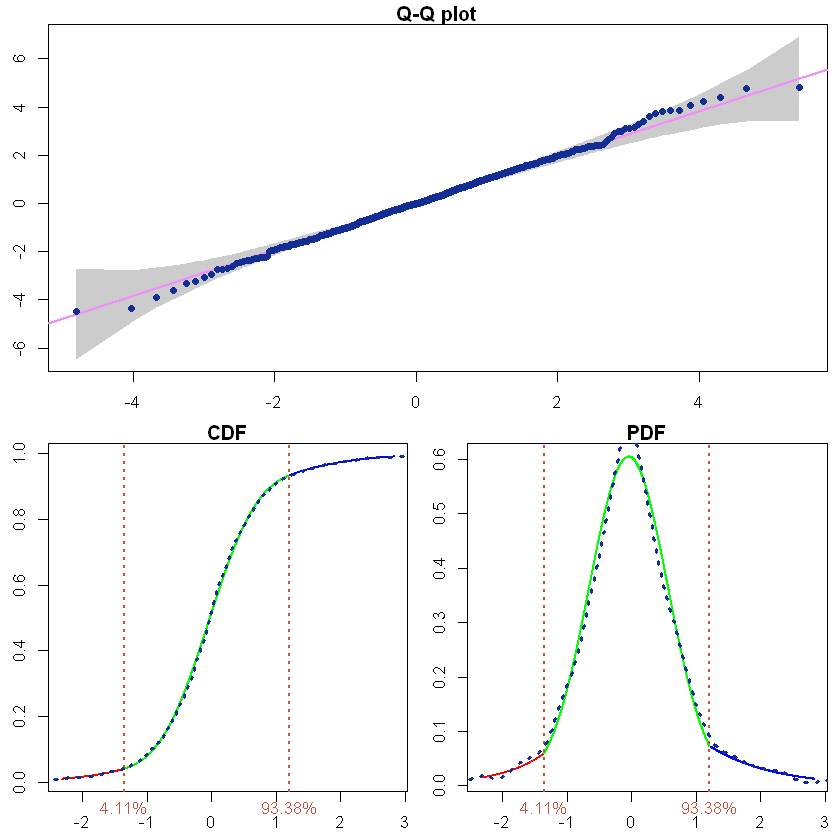

In [107]:
evt_security <- GNG_fit(security_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_security
plot(evt_security)

In [109]:
#下尾形状参数0.0047尺度参数0.6892 上尾形状参数-0.0613尺度参数0.9114
distribution(evt_security)

Composite distribution with: 
 
  Trafo       Distribution                                    Parameters Weight
1  -X   Generalized Pareto loc = 1.3577, scale = 0.6892, shape = 0.0047  0.0411
2 none        Normal                mean = -0.044, sd = 0.6103           0.8927
3 none  Generalized Pareto loc = 1.2129, scale = 0.9114, shape = -0.0613 0.0662
        Truncation
1  (-Inf,-1.3577) 
2 [-1.3577,1.2129)
3   [1.2129,Inf)  

In [110]:
data_res <- cbind(fintech_res, bank_res, fund_res, stock_res, security_res)
write.csv(data_res, "E:\\时间序列期末\\residuals.csv")
ts_df_1 <- read.csv("E:\\时间序列期末\\residuals.csv")

In [111]:
dim(ts_df_1)
tail(ts_df_1)
tail(data_res)

[1] 1678    6

,X,fintech_res,bank_res,fund_res,stock_res,security_res
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1673,1673,-1.88005276,0.7893468,-1.28781856,-0.5264179,-0.47733415
1674,1674,1.78924427,0.4941990,-0.56308532,1.2481220,1.29541631
1675,1675,-0.04012605,0.3598514,0.64718059,0.1729186,0.30006540
1676,1676,-0.80141927,0.5256708,0.29904964,-0.5671140,-0.27762069
1677,1677,0.17766124,-1.0142833,0.05742677,-0.2994014,0.34772487
1678,1678,0.27698175,0.3534052,-0.18191591,-0.4611304,-0.07116529


           fintech_res   bank_res    fund_res  stock_res security_res
2024-04-16 -1.88005276  0.7893468 -1.28781856 -0.5264179  -0.47733415
2024-04-17  1.78924427  0.4941990 -0.56308532  1.2481220   1.29541631
2024-04-18 -0.04012605  0.3598514  0.64718059  0.1729186   0.30006540
2024-04-19 -0.80141927  0.5256708  0.29904964 -0.5671140  -0.27762069
2024-04-22  0.17766124 -1.0142833  0.05742677 -0.2994014   0.34772487
2024-04-23  0.27698175  0.3534052 -0.18191591 -0.4611304  -0.07116529

调整数据结构

In [112]:
o <- order(ts_df_1$fintech_res)
rd1 <- cbind(ts_df_1$fintech_res[o], ts_df_1$bank_res[o], ts_df_1$fund_res[o], ts_df_1$stock_res[o], ts_df_1$security_res[o])

x <- rd1[, 1]
#bank
y1 <- rd1[, 2]
#fund
y2 <- rd1[, 3]
#stock
y3 <- rd1[, 4]
#security
y4 <- rd1[, 5]
#香蜜湖&银行
Dat1 <- NULL
Dat1$x <- x
Dat1$y <- y1
#香蜜湖&基金
Dat2 <- NULL
Dat2$x <- x
Dat2$y <- y2
#香蜜湖&股票
Dat3 <- NULL
Dat3$x <- x
Dat3$y <- y3
#香蜜湖&证券
Dat4 <- NULL
Dat4$x <- x
Dat4$y <- y4

In [113]:
#copula集合
# √ Clayton copula
conditional_clayton_copula <- function(u, v, delta) {
  (1 + u^delta * (v^(-delta) - 1))^(-1 / delta - 1)
}

# √ Rotated Clayton copula
conditional_rotated_clayton_copula <- function(u, v, delta) {
  1 - (1 + (1 - u)^delta * ((1 - v)^(-delta) - 1))^(-1 / delta - 1)
}

# √ Joe copula
conditional_joe_copula <- function(u, v, delta) {
  term1 <- 1 + (1 - u)^(-delta) * (1 - v)^delta - (1 - v)^delta
  term2 <- (1 - (1 - v)^delta)
  result <- (term1)^((1 - delta) / delta) * term2
  return(result)
}


# √ Rotated Joe copula
conditional_rotated_joe_copula <- function(u, v, delta) {
  term1 <- 1 + u^(-delta) * v^delta - v^delta
  term2 <- (1 - v^delta)
  result <- 1 - (term1)^((1 - delta) / delta) * term2
  return(result)
}

#test gumbel copula
# Gumbel copula
gumbel_copula <- function(u, v, delta) {
  exp(-((-log(u))^delta + (-log(v))^delta)^(1/delta))
}

# Gumbel copula conditional distribution function
conditional_gumbel_copula <- function(u, v, delta) {
  term1 <- u^(-1)
  term2 <- gumbel_copula(u, v, delta)
  term3 <- (1 + (log(v) / log(u))^delta)^((1 - delta) / delta)
  result <- term1 * term2 * term3
  return(result)
}


# Rotated Gumbel copula
rotated_gumbel_copula <- function(u, v, delta) {
  u + v - 1 + gumbel_copula(1 - u, 1 - v, delta)
}

# Rotated Gumbel copula conditional distribution function
conditional_rotated_gumbel_copula <- function(u, v, delta) {
  term1 <- (1 - u)^(-1)
  term2 <- gumbel_copula(1 - u, 1 - v, delta)
  term3 <- (1 + (log(1 - v) / log(1 - u))^delta)^((1 - delta) / delta)
  result <- 1 - term1 * term2 * term3
  return(result)
}

# Galambos copula
galambos_copula <- function(u, v, delta) {
  u * v * exp(-(((-log(u))^(-delta) + (-log(v))^(-delta))^(-1/delta)))
}

# Galambos copula conditional distribution function
conditional_galambos_copula <- function(u, v, delta) {
  term1 <- u^(-1)
  term2 <- galambos_copula(u, v, delta)
  term3 <- 1 - (1 + (log(u) / log(v))^delta)^(-(1 + delta) / delta)
  result <- term1 * term2 * term3
  return(result)
}


# Galambos copula
galambos_copula <- function(u, v, delta) {
  u * v * exp(-(((-log(u))^(-delta) + (-log(v))^(-delta))^(-1/delta)))
}

# Rotated Galambos copula
rotated_galambos_copula <- function(u, v, delta) {
  u + v - 1 + galambos_copula(1 - u, 1 - v, delta)
}

# Rotated Galambos copula conditional distribution function
conditional_rotated_galambos_copula <- function(u, v, delta) {
  term1 <- (1 - u)^(-1)
  term2 <- galambos_copula(1 - u, 1 - v, delta)
  term3 <- 1 - (1 + (log(1 - u) / log(1 - v))^delta)^(-(1 + delta) / delta)
  result <- 1 - term1 * term2 * term3
  return(result)
}


# Load the necessary package for the phi function
library(stats)

# Hüsler-Reiss copula
husler_reiss_copula <- function(u, v, delta) {
  phi_u <- pnorm(delta^-1 + 0.5 * delta * log(log(u) / log(v)))
  phi_v <- pnorm(delta^-1 + 0.5 * delta * log(log(v) / log(u)))
  result <- exp(phi_u * log(u) + phi_v * log(v))
  return(result)
}

# Hüsler-Reiss copula conditional distribution function
conditional_husler_reiss_copula <- function(u, v, delta) {
  phi_u <- pnorm(delta^-1 + 0.5 * delta * log(log(u) / log(v)))
  copula_value <- husler_reiss_copula(u, v, delta)
  result <- copula_value * u^-1 * phi_u
  return(result)
}


# Rotated Hüsler-Reiss copula
rotated_husler_reiss_copula <- function(u, v, delta) {
  u + v - 1 + husler_reiss_copula(1 - u, 1 - v, delta)
}

# Rotated Hüsler-Reiss copula conditional distribution function
conditional_rotated_husler_reiss_copula <- function(u, v, delta) {
  phi <- pnorm(delta^-1 + 0.5 * delta * log(log(1 - u) / log(1 - v)))
  copula_value <- husler_reiss_copula(1 - u, 1 - v, delta)
  result <- 1 - copula_value * (1 - u)^-1 * phi
  return(result)
}



香蜜湖&银行covar

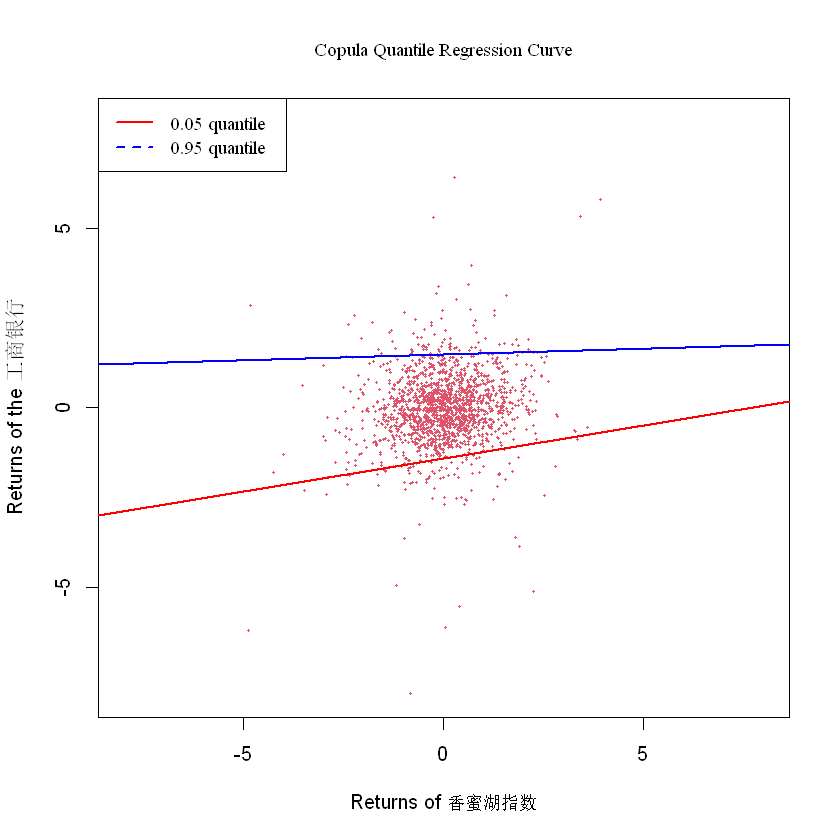

In [114]:
rq05 <- rq(y1 ~ x, tau = 0.05, data = Dat1)  # 0.05分位数回归
rq95 <- rq(y1 ~ x, tau = 0.95, data = Dat1)  # 0.95分位数回归
# 绘制基础图形
plot(x, y1, col = 2, cex = 0.5, pch = 20, xlim = c(-8, 8), ylim = c(-8, 8),
     main = 'Copula Quantile Regression Curve', font.main = 6, cex.main = 0.95,
     xlab = 'Returns of 香蜜湖指数', ylab = 'Returns of the 工商银行')

# 添加分位数回归线
abline(rq05, col = "red", lwd = 2)  # 0.05分位数线
abline(rq95, col = "blue", lwd = 2)  # 0.95分位数线

# 添加图例
legend('topleft', c("0.05 quantile", "0.95 quantile"), col = c("red", "blue"),   
       lty = c(1, 2), lwd = c(2, 2), cex = 0.95, text.font = 6)

In [115]:
#香蜜湖
u <- p(distribution(evt_fintech),x)

In [116]:
# 初始化deltas矩阵
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 适当调整行数和列数
}

GumbelModel <- function(x, alpha, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){1 - exp(-((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^(1/alpha)) * 
    (((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^((1/alpha) - 
        1) * ((1/alpha) * ((-log(1 - u[i]))^(alpha - 1) * (alpha * 
        (1/(1 - u[i]))))))-tau}
vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_bank),v)
mu + sigma * z
}
##mu is the panning parameter and sigma is the zooming parameter 

内点法得到delta（下行风险）

189.342 :   1.1257506 -0.1261274  1.0103893 
final  value 186.276949 
converged
lambda = 0.1767771 
186.2769 :  1.11684850 0.02315548 0.95454239 
final  value 184.776803 
stopped after 6 iterations
lambda = 0.2041083 
184.7768 :  1.0419530 0.4296274 1.1979488 
final  value 184.774600 
stopped after 2 iterations
lambda = 0.002450854 
184.7746 :  1.0410344 0.4605112 1.2185506 
final  value 184.774600 
converged
lambda = 0 
184.7746 :  1.0410344 0.4605112 1.2185506 



Call: nlrq(formula = y1 ~ GumbelModel(x, delta, mu, sigma, tau), data = Dat1, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.04103  0.27574    3.77543  0.00017
mu     0.46051 11.25501    0.04092  0.96737
sigma  1.21855  7.62711    0.15977  0.87308

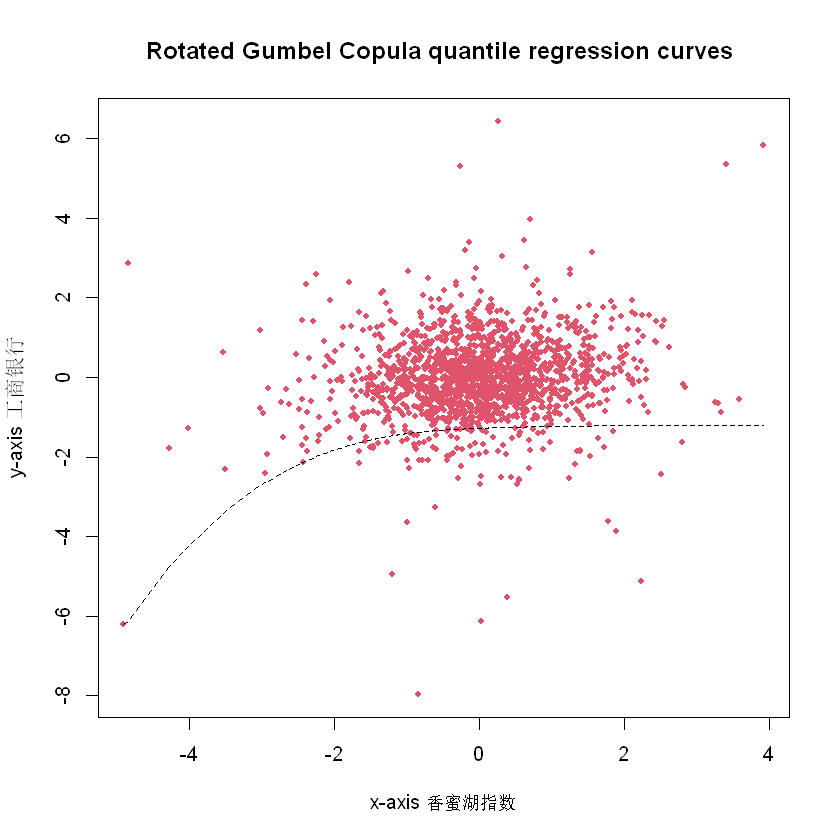

In [117]:

tau = 0.05
fit3 <- nlrq(y1 ~ GumbelModel(x, delta,mu, sigma, tau),
data=Dat1, tau=tau, start = list(delta=1.1257506, mu=-0.1261274, sigma=1.0103893), trace=TRUE)
plot(x, y1, main="Rotated Gumbel Copula quantile regression curves ", xlab="x-axis 香蜜湖指数", ylab="y-axis 工商银行", type='p',col = 2, pch=20)
lines(x, predict(fit3, newdata = x), lty = 2, lwd = 1, col = 1)
deltas[3,] <- coef(fit3)
summary(fit3)

In [118]:
#Gumbel copula quantile regression model
u <- p(distribution(evt_fintech),x)
uGumbelModel <- function(x, delta, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){exp(-((-log(u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u[i]))^(delta - 1) * (delta * (1/u[i])))))-tau}
vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_bank),v)
mu + sigma * z
}

同上 是上行风险（？好像是没优化出结果

In [119]:
tau=0.95
fit1 <- nlrq(y1 ~ uGumbelModel(x, delta, mu, sigma, tau),
data=Dat1, tau=tau, start=list(delta=1.2, mu=0.2, sigma=1.0), trace=TRUE)
plot(x, y1, main="Gumbel Copula quantile regression curves ", xlab="x-axis 香蜜湖指数", ylab="y-axis 工商银行", type='p',col = 2, pch=20)
lines(x, predict(fit1, newdata=x), lty=2, lwd=1, col=1)
deltas[3,] <- coef(fit1)
summary(fit1)

186.2857 :  1.2 0.2 1.0 
final  value 185.959605 
converged
lambda = 0.04119459 
185.9596 :  1.1871312 0.1257855 1.0062875 
final  value 182.807553 
stopped after 7 iterations
lambda = 0.1787924 
182.8076 :   1.0386874 -0.4549497  1.2950741 
final  value 182.782773 
converged
lambda = 0.009692753 
182.7828 :   1.0335138 -0.6884553  1.4450820 
Error in uniroot(rootf1, c(1e-09, 0.9999999999)) : 
  f() values at end points not of opposite sign


ERROR: Error in nlrq.calc(m, ctrl, trace): optim unable to find valid step size


计算下行风险

In [120]:
######estimate the CoVaR######tau=0.05
tau <- 0.05
u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3)[1]
mu <- coef(fit3)[2]
sigma <- coef(fit3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1<-function(v){1 - exp(-((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^(1/delta)) * 
    (((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^((1/delta) -
        1) * ((1/delta) * ((-log(1 - u_u[i]))^(delta - 1) * (delta *
        (1/(1 - u_u[i]))))))-tau}
vx<-uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- qsstd(v_x[i])
}

z_u <- v_f

f_hat_u <- mu+sigma*z_u


In [121]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_bank) + sigma(filt_bank)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_bank) + sigma(filt_bank)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_bank) + sigma(filt_bank)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_bank) + sigma(filt_bank)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050


In [122]:
delta_CoVaR_005_001

           m.c.seq.row..seq.n...seq.col..drop...FALSE.
2017-05-31                                  -0.6395694
2017-06-01                                  -0.6395694
2017-06-02                                  -0.6810894
2017-06-05                                  -0.6316887
2017-06-06                                  -0.7103898
2017-06-07                                  -0.6531417
2017-06-08                                  -0.6233381
2017-06-09                                  -0.5768163
2017-06-12                                  -0.5350284
2017-06-13                                  -0.5051719
       ...                                            
2024-04-10                                  -0.6544755
2024-04-11                                  -0.6171563
2024-04-12                                  -0.5831682
2024-04-15                                  -0.5387071
2024-04-16                                  -0.6629996
2024-04-17                                  -0.6854415
2024-04-18

计算上行风险(?

In [123]:
##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1)[1]
mu <- coef(fit1)[2]
sigma <- coef(fit1)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1 <- function(v){
exp(-((-log(u_u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u_u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u_u[i]))^(delta - 1) * (delta * (1/u_u[i])))))-tau
}
vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- qsstd(v_x[i])
}

z_u <- v_f 

f_hat_u <- mu+sigma*z_u


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'coef': object 'fit1' not found


           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005
2017-05-31     -1.184731     -1.426606          -0.2418751
2017-06-01     -1.192904     -1.434779          -0.2418751
2017-06-02     -1.300250     -1.557828          -0.2575773
2017-06-05     -1.212688     -1.451582          -0.2388947
2017-06-06     -1.282699     -1.551357          -0.2686582
2017-06-07     -1.137235     -1.384243          -0.2470079

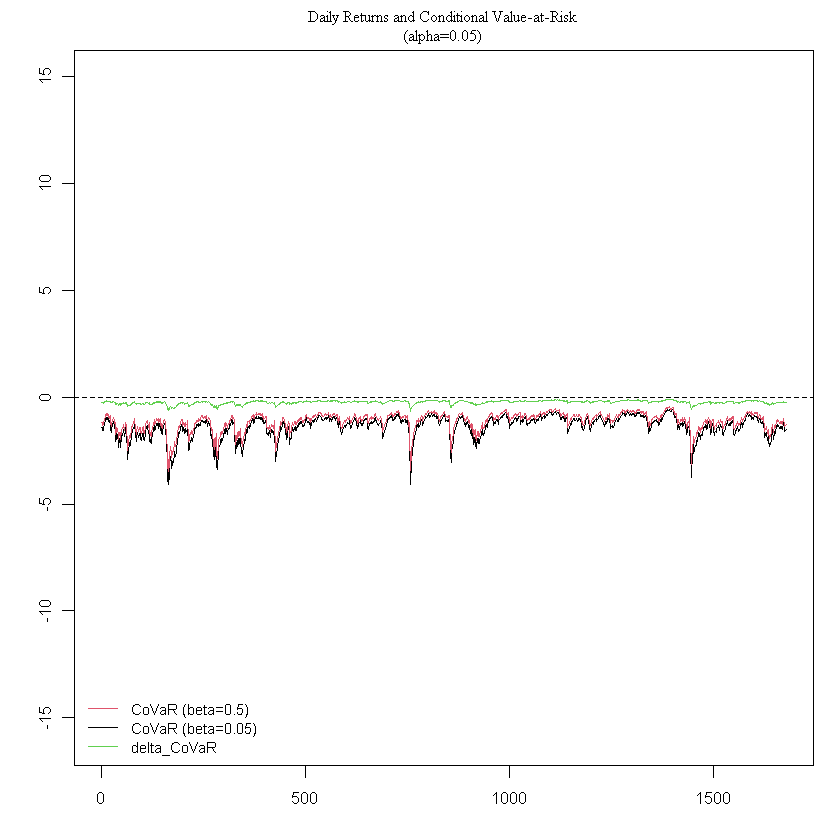

In [124]:
##plot the dynamic CoVaR and delta CoVaR（仅下行风险
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$bank)
tt <- seq(1:length(ts_df_1$bank))
plot(tt,ts_df$bank, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$bank, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
#lines(tt,CoVaR_095_005, lwd = 1, col = 1)
#lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
#lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
#CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$bank)

head(dynamic)

香蜜湖&基金covar

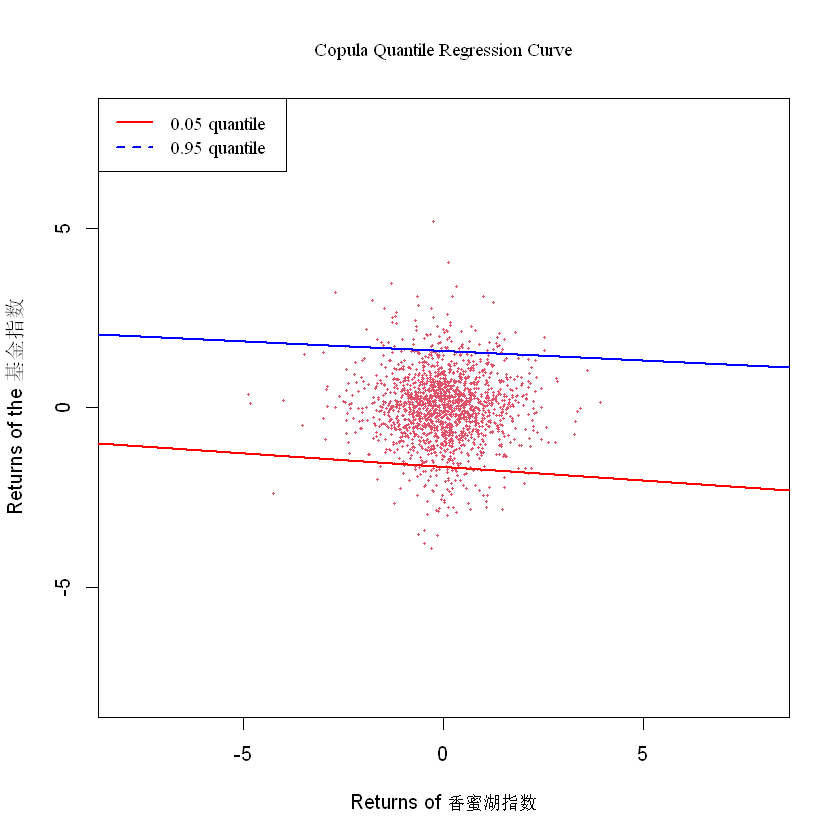

In [125]:
rq05 <- rq(y2 ~ x, tau = 0.05, data = Dat2)  # 0.05分位数回归
rq95 <- rq(y2 ~ x, tau = 0.95, data = Dat2)  # 0.95分位数回归
# 绘制基础图形
plot(x, y2, col = 2, cex = 0.5, pch = 20, xlim = c(-8, 8), ylim = c(-8, 8),
     main = 'Copula Quantile Regression Curve', font.main = 6, cex.main = 0.95,
     xlab = 'Returns of 香蜜湖指数', ylab = 'Returns of the 基金指数')

# 添加分位数回归线
abline(rq05, col = "red", lwd = 2)  # 0.05分位数线
abline(rq95, col = "blue", lwd = 2)  # 0.95分位数线

# 添加图例
legend('topleft', c("0.05 quantile", "0.95 quantile"), col = c("red", "blue"),   
       lty = c(1, 2), lwd = c(2, 2), cex = 0.95, text.font = 6)

In [126]:
# 初始化deltas矩阵
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 适当调整行数和列数
}

GumbelModel <- function(x, alpha, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){1 - exp(-((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^(1/alpha)) * 
    (((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^((1/alpha) - 
        1) * ((1/alpha) * ((-log(1 - u[i]))^(alpha - 1) * (alpha * 
        (1/(1 - u[i]))))))-tau}
vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_fund),v)
mu + sigma * z
}
##mu is the panning parameter and sigma is the zooming parameter 

In [127]:
tau = 0.05
fit3_2 <- nlrq(y2 ~ GumbelModel(x, delta,mu, sigma, tau),
data=Dat2, tau=tau, start = list(delta=1.1257506, mu=-0.1261274, sigma=1.0103893), trace=TRUE)
plot(x, y2, main="Rotated Gumbel Copula quantile regression curves ", xlab="x-axis 香蜜湖指数", ylab="y-axis 基金指数", type='p',col = 2, pch=20)
lines(x, predict(fit3_2, newdata = x), lty = 2, lwd = 1, col = 1)
deltas[3,] <- coef(fit3_2)
summary(fit3_2)

200.7055 :   1.1257506 -0.1261274  1.0103893 
final  value 200.387839 
converged
lambda = 0.07691742 
200.3878 :   1.1246394 -0.1492098  0.9276247 
final  value 190.825161 
stopped after 4 iterations
lambda = 0.9565005 
190.8252 :   0.9458159 -1.1995901  0.2521950 
final  value 190.793821 
converged
lambda = 0.02104667 
190.7938 :   0.9319816 -1.2804641  0.2047224 
Error in uniroot(rootf1, c(1e-11, 0.999999999999)) : 
  f() values at end points not of opposite sign


ERROR: Error in nlrq.calc(m, ctrl, trace): optim unable to find valid step size


In [128]:
#Gumbel copula quantile regression model
u <- p(distribution(evt_fintech),x)
uGumbelModel <- function(x, delta, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){exp(-((-log(u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u[i]))^(delta - 1) * (delta * (1/u[i])))))-tau}
vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_fund),v)
mu + sigma * z
}

香蜜湖&股票（看上去是比较标准的一个）以此为例子带着evt调整

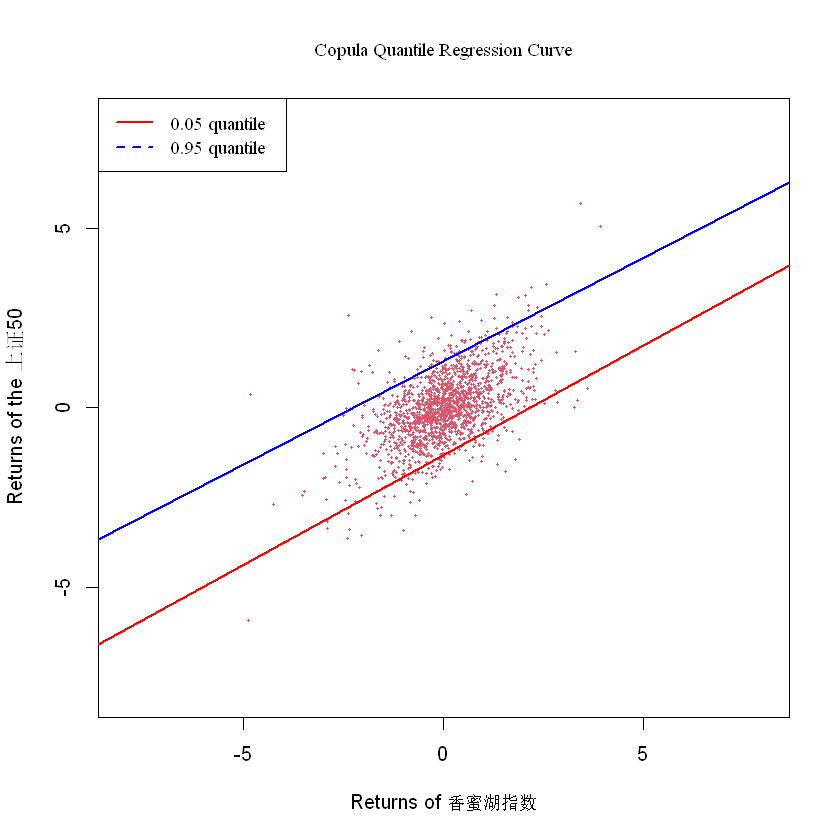

In [129]:
rq05 <- rq(y3 ~ x, tau = 0.05, data = Dat3)  # 0.05分位数回归
rq95 <- rq(y3 ~ x, tau = 0.95, data = Dat3)  # 0.95分位数回归
# 绘制基础图形
plot(x, y3, col = 2, cex = 0.5, pch = 20, xlim = c(-8, 8), ylim = c(-8, 8),
     main = 'Copula Quantile Regression Curve', font.main = 6, cex.main = 0.95,
     xlab = 'Returns of 香蜜湖指数', ylab = 'Returns of the 上证50')

# 添加分位数回归线
abline(rq05, col = "red", lwd = 2)  # 0.05分位数线
abline(rq95, col = "blue", lwd = 2)  # 0.95分位数线

# 添加图例
legend('topleft', c("0.05 quantile", "0.95 quantile"), col = c("red", "blue"),   
       lty = c(1, 2), lwd = c(2, 2), cex = 0.95, text.font = 6)

In [130]:
# 初始化deltas矩阵
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 适当调整行数和列数
}
#
GumbelModel <- function(x, alpha, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){1 - exp(-((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^(1/alpha)) * 
    (((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^((1/alpha) - 
     1) * ((1/alpha) * ((-log(1 - u[i]))^(alpha - 1) * (alpha * 
    (1/(1 - u[i]))))))-tau}
vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_stock), v)
mu + sigma * z
}
##mu is the panning parameter and sigma is the zooming parameter 


156.3375 :   1.1257506 -0.1261274  1.0103893 
final  value 148.553435 
stopped after 6 iterations
lambda = 0.2353705 
148.5534 :   1.18732346 -0.01324508  0.88877865 
final  value 142.831309 
converged
lambda = 1 
142.8313 :   1.5031118 -0.2186985  0.8604929 
final  value 140.676760 
stopped after 5 iterations
lambda = 0.9647517 
140.6768 :   2.1002361 -0.4591906  0.8984138 
final  value 140.403104 
converged
lambda = 0.8274135 
140.4031 :   2.5423372 -0.5554241  0.9331132 
final  value 140.250562 
converged
lambda = 1 
140.2506 :   2.8410692 -0.5914544  0.9222198 
final  value 139.998095 
converged
lambda = 0.9094669 
139.9981 :   2.4049341 -0.4561200  0.9491076 
final  value 139.697558 
stopped after 4 iterations
lambda = 0.8624552 
139.6976 :   2.1202058 -0.3140111  0.9904312 
final  value 139.786581 
converged
lambda = 1 
139.7866 :   2.1287540 -0.2725804  1.0061301 



Call: nlrq(formula = y3 ~ GumbelModel(x, delta, mu, sigma, tau), data = Dat3, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  2.12875  0.59992    3.54840  0.00040
mu    -0.27258  0.31968   -0.85266  0.39397
sigma  1.00613  0.12079    8.32977  0.00000

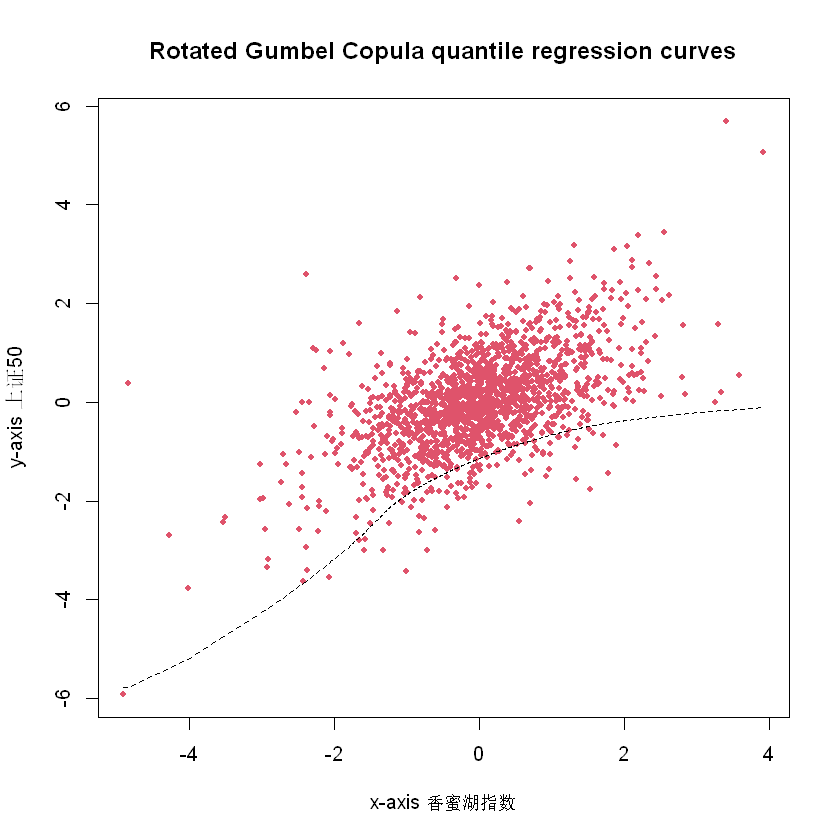

In [131]:
tau = 0.05
fit3_3 <- nlrq(y3 ~ GumbelModel(x, delta,mu, sigma, tau),
data=Dat3, tau=tau, start = list(delta=1.1257506, mu=-0.1261274, sigma=1.0103893), trace=TRUE)
plot(x, y3, main="Rotated Gumbel Copula quantile regression curves", xlab="x-axis 香蜜湖指数", ylab="y-axis 上证50", type='p',col = 2, pch=20)
lines(x, predict(fit3_3, newdata = x), lty = 2, lwd = 1, col = 1)
deltas[3,] <- coef(fit3_3)
summary(fit3_3)

In [132]:
#Gumbel copula quantile regression model
u <- p(distribution(evt_fintech),x)
uGumbelModel <- function(x, delta, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){exp(-((-log(u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u[i]))^(delta - 1) * (delta * (1/u[i])))))-tau}
vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_stock),v)
mu + sigma * z
}

156.3897 :  1.2157506 0.1861274 1.0158930 
final  value 148.044135 
converged
lambda = 0.2231651 
148.0441 :  1.2853439 0.0143575 0.9541224 
final  value 144.813646 
converged
lambda = 1 
144.8136 :   1.51789089 -0.07330165  1.06349674 
final  value 144.537489 
converged
lambda = 0.4482674 
144.5375 :   1.4133698 -0.2243625  1.1338482 
final  value 144.532057 
stopped after 3 iterations
lambda = 0.02196996 
144.5321 :   1.4091075 -0.2291336  1.1362741 
final  value 144.532057 
converged
lambda = 0 
144.5321 :   1.4091075 -0.2291336  1.1362741 



Call: nlrq(formula = y3 ~ uGumbelModel(x, delta, mu, sigma, tau), data = Dat3, 
    start = list(delta = 1.2157506, mu = 0.1861274, sigma = 1.015893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.95

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.40911  0.37246    3.78324  0.00016
mu    -0.22913  0.73818   -0.31040  0.75629
sigma  1.13627  0.36773    3.09000  0.00203

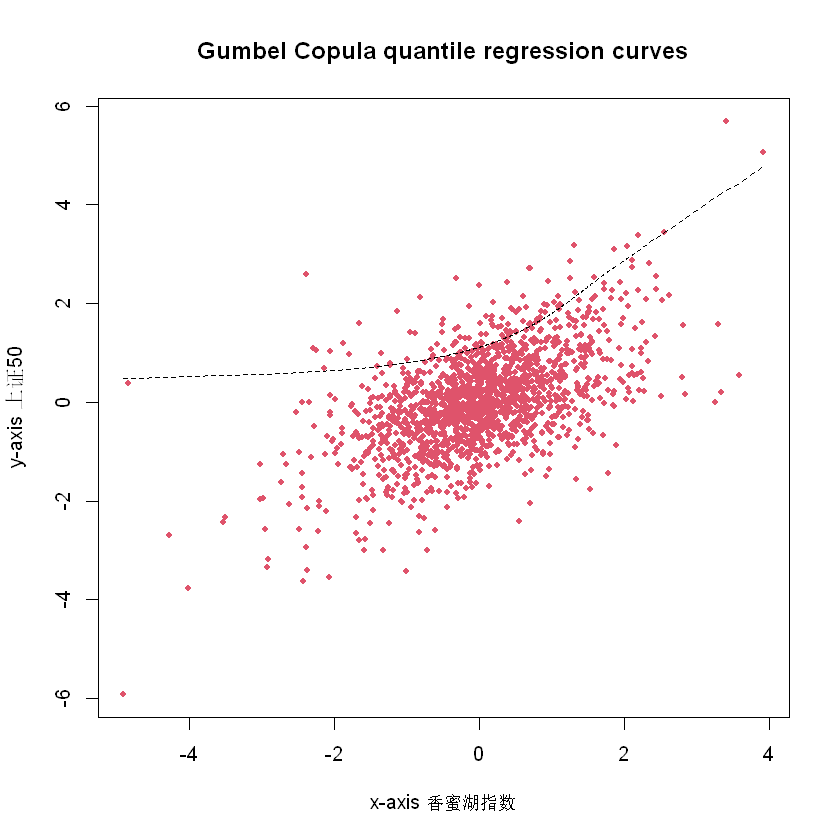

In [133]:
tau=0.95
fit1_3 <- nlrq(y3 ~ uGumbelModel(x, delta, mu, sigma, tau),
data=Dat3, tau=tau, start=list(delta=1.2157506, mu=0.1861274, sigma=1.015893), trace=TRUE)
plot(x, y3, main="Gumbel Copula quantile regression curves", xlab="x-axis 香蜜湖指数", ylab="y-axis 上证50", type='p',col = 2, pch=20)
lines(x, predict(fit1_3, newdata=x), lty=2, lwd=1, col=1)
deltas[3,] <- coef(fit1_3)
summary(fit1_3)

In [134]:
#########################estimate the CoVaR######tau=0.05
tau <- 0.05
u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3_3)[1]
mu <- coef(fit3_3)[2]
sigma <- coef(fit3_3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1<-function(v){1 - exp(-((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^(1/delta)) * 
    (((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^((1/delta) -
        1) * ((1/delta) * ((-log(1 - u_u[i]))^(delta - 1) * (delta *
        (1/(1 - u_u[i]))))))-tau}
vx<-uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f

f_hat_u <- mu+sigma*z_u

In [135]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050

In [136]:
##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1_3)[1]
mu <- coef(fit1_3)[2]
sigma <- coef(fit1_3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1 <- function(v){
exp(-((-log(u_u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u_u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u_u[i]))^(delta - 1) * (delta * (1/u_u[i])))))-tau
}
vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- mistr_q(distribution(evt_stock), v_x[i])
}

z_u <- v_f 

f_hat_u <- mu+sigma*z_u


In [137]:
###upside CoVaR
CoVaR_095_050 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[1]
CoVaR_095_010 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[2]
delta_CoVaR_095_010<-CoVaR_095_010-CoVaR_095_050

CoVaR_095_005 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[3]
delta_CoVaR_095_005<-CoVaR_095_005-CoVaR_095_050

CoVaR_095_001 = fitted(filt_stock) + sigma(filt_stock)*f_hat_u[4]
delta_CoVaR_095_001 <- CoVaR_095_001-CoVaR_095_050

           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005 CoVaR_095_050
2017-05-31     -1.358692     -3.131229           -1.772537      1.342548
2017-06-01     -1.359022     -3.131559           -1.772537      1.342218
2017-06-02     -1.334837     -3.067281           -1.732444      1.305304
2017-06-05     -1.351668     -3.104778           -1.753110      1.319967
2017-06-06     -1.352648     -3.148027           -1.795379      1.383402
2017-06-07     -1.337818     -3.084971           -1.747152      1.324738
           CoVaR_095_005 delta_CoVaR_095_005
2017-05-31      2.948726            1.606178
2017-06-01      2.948396            1.606178
2017-06-02      2.875151            1.569847
2017-06-05      2.908541            1.588574
2017-06-06      3.010278            1.626876
2017-06-07      2.907913            1.583176

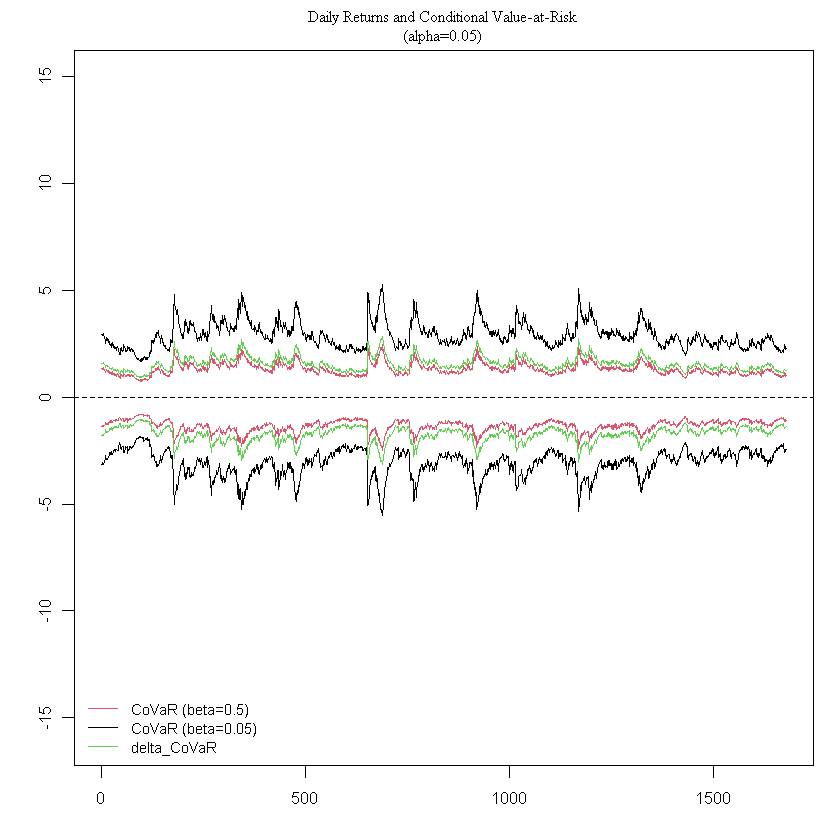

In [138]:
##plot the dynamic CoVaR and delta CoVaR
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$stock)
tt <- seq(1:length(ts_df_1$stock))
plot(tt,ts_df$stock, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$stock, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
lines(tt,CoVaR_095_005, lwd = 1, col = 1)
lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$stock)

head(dynamic)

这个图像看着好奇怪 上下看上去为什么像完全对称的、、是之前哪里弄的不对吗

香蜜湖&证券

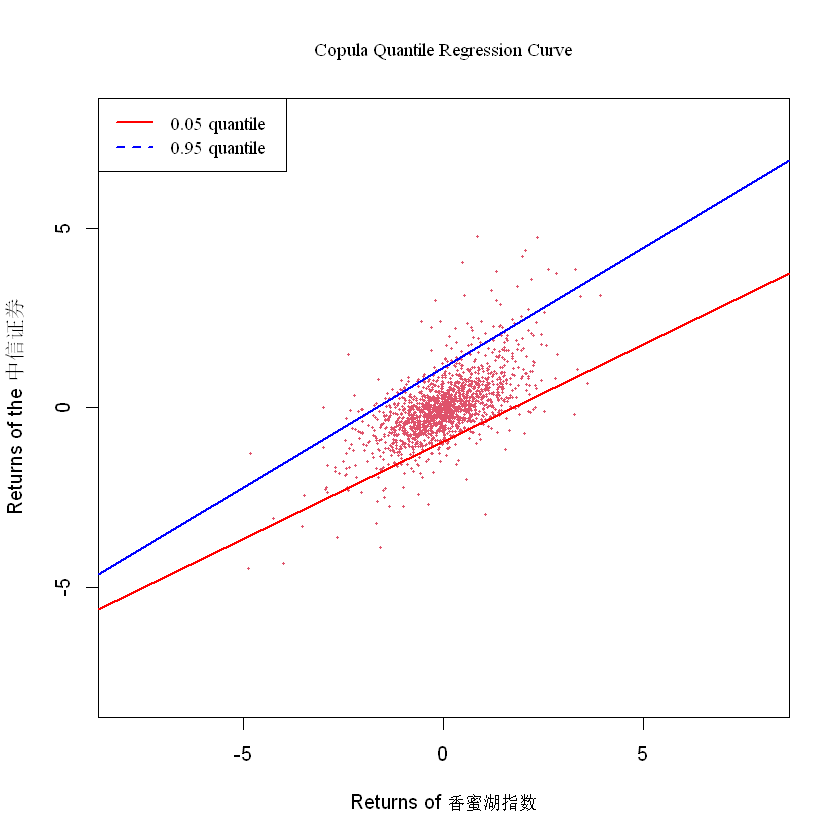

In [139]:
rq05 <- rq(y4 ~ x, tau = 0.05, data = Dat4)  # 0.05分位数回归
rq95 <- rq(y4 ~ x, tau = 0.95, data = Dat4)  # 0.95分位数回归
# 绘制基础图形
plot(x, y4, col = 2, cex = 0.5, pch = 20, xlim = c(-8, 8), ylim = c(-8, 8),
     main = 'Copula Quantile Regression Curve', font.main = 6, cex.main = 0.95,
     xlab = 'Returns of 香蜜湖指数', ylab = 'Returns of the 中信证券')

# 添加分位数回归线
abline(rq05, col = "red", lwd = 2)  # 0.05分位数线
abline(rq95, col = "blue", lwd = 2)  # 0.95分位数线

# 添加图例
legend('topleft', c("0.05 quantile", "0.95 quantile"), col = c("red", "blue"),   
       lty = c(1, 2), lwd = c(2, 2), cex = 0.95, text.font = 6)

In [140]:
# 初始化deltas矩阵
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 适当调整行数和列数
}

GumbelModel <- function(x, alpha, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){1 - exp(-((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^(1/alpha)) * 
    (((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^((1/alpha) - 
        1) * ((1/alpha) * ((-log(1 - u[i]))^(alpha - 1) * (alpha * 
        (1/(1 - u[i]))))))-tau}
vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_security),v)
mu + sigma * z
}
##mu is the panning parameter and sigma is the zooming parameter 

132.259 :   1.1257506 -0.1261274  1.0103893 
final  value 121.543356 
converged
lambda = 0.2842094 
121.5434 :   1.21334483 -0.07099737  0.81802880 
final  value 120.523520 
converged
lambda = 0.0954829 
120.5235 :   1.3456552 -0.2099614  0.7312081 
final  value 117.951410 
stopped after 2 iterations
lambda = 0.4546679 
117.9514 :   1.9963095 -0.4258039  0.6807313 
final  value 114.106640 
converged
lambda = 0.7413572 
114.1066 :   3.7444515 -0.5903575  0.8301006 
final  value 113.036137 
stopped after 5 iterations
lambda = 0.839696 
113.0361 :   3.6024932 -0.4714422  0.9373140 
final  value 113.010397 
stopped after 4 iterations
lambda = 0.1534288 
113.0104 :   3.3807968 -0.4429116  0.9538457 
final  value 112.893444 
converged
lambda = 0.4966625 
112.8934 :   2.6273043 -0.2777171  1.0185941 
final  value 112.893444 
converged
lambda = 0 
112.8934 :   2.6273043 -0.2777171  1.0185941 



Call: nlrq(formula = y4 ~ GumbelModel(x, delta, mu, sigma, tau), data = Dat4, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  2.62730  0.71818    3.65828  0.00026
mu    -0.27772  0.22189   -1.25161  0.21089
sigma  1.01859  0.14105    7.22164  0.00000

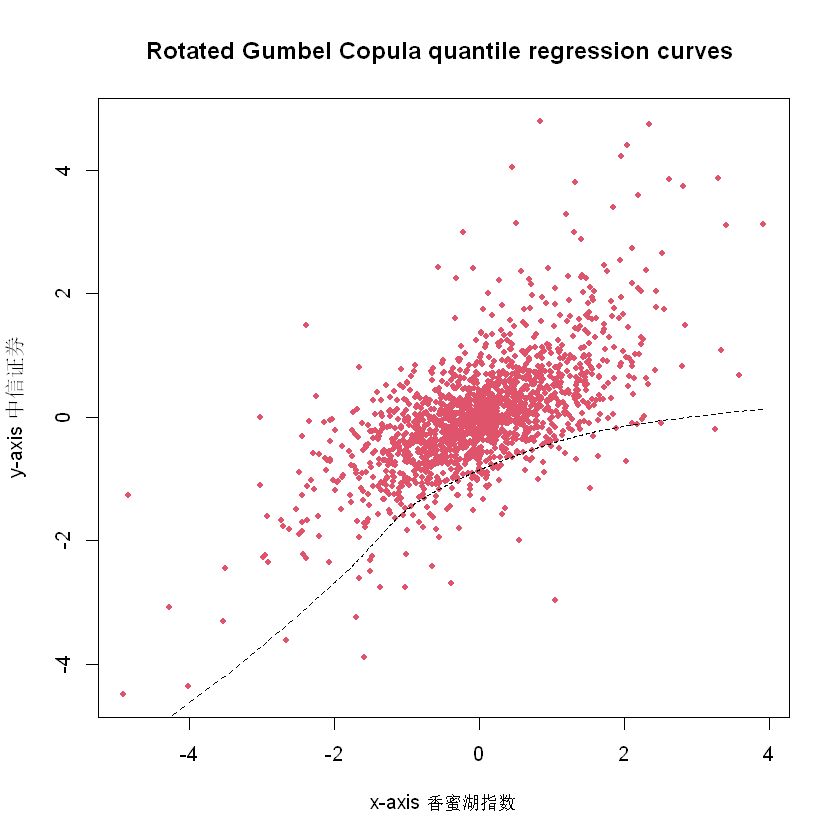

In [141]:
tau = 0.05
fit3_4 <- nlrq(y4 ~ GumbelModel(x, delta,mu, sigma, tau),
data=Dat4, tau=tau, start = list(delta=1.1257506, mu=-0.1261274, sigma=1.0103893), trace=TRUE)
plot(x, y4, main="Rotated Gumbel Copula quantile regression curves ", xlab="x-axis 香蜜湖指数", ylab="y-axis 中信证券", type='p',col = 2, pch=20)
lines(x, predict(fit3_4, newdata = x), lty = 2, lwd = 1, col = 1)
deltas[3,] <- coef(fit3_4)
summary(fit3_4)

In [147]:
#Gumbel copula quantile regression model
u <- p(distribution(evt_fintech),x)
uGumbelModel <- function(x, delta, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){exp(-((-log(u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u[i]))^(delta - 1) * (delta * (1/u[i])))))-tau}
vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_security),v)
mu + sigma * z
}

165.1147 :  1.2157506 0.1861274 1.0158930 
final  value 147.101494 
converged
lambda = 0.4132434 
147.1015 :  1.42317026 0.07125152 0.80549078 
final  value 135.622611 
converged
lambda = 0.6951166 
135.6226 :   1.8524928 -0.2145442  1.2055866 
final  value 135.622611 
converged
lambda = 0 
135.6226 :   1.8524928 -0.2145442  1.2055866 



Call: nlrq(formula = y4 ~ uGumbelModel(x, delta, mu, sigma, tau), data = Dat4, 
    start = list(delta = 1.2157506, mu = 0.1861274, sigma = 1.015893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.95

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.85249  0.49102    3.77271  0.00017
mu    -0.21454  0.53329   -0.40230  0.68751
sigma  1.20559  0.26922    4.47807  0.00001

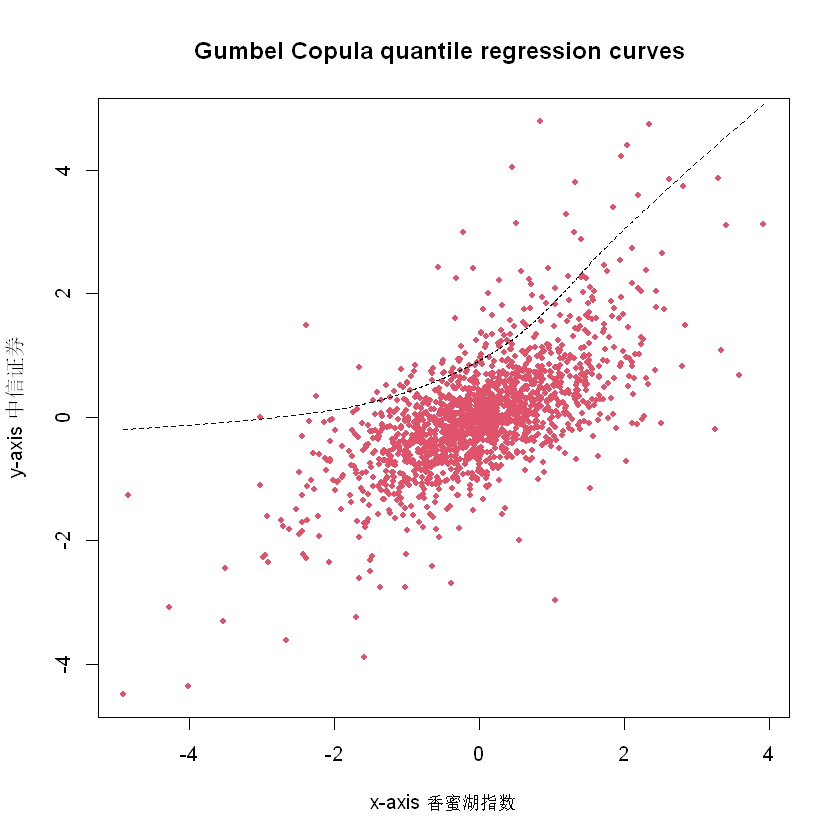

In [145]:
tau=0.95
fit1_4 <- nlrq(y4 ~ uGumbelModel(x, delta, mu, sigma, tau),
data=Dat4, tau=tau, start=list(delta=1.2157506, mu=0.1861274, sigma=1.015893), trace=TRUE)
plot(x, y4, main="Gumbel Copula quantile regression curves ", xlab="x-axis 香蜜湖指数", ylab="y-axis 中信证券", type='p',col = 2, pch=20)
lines(x, predict(fit1_4, newdata=x), lty=2, lwd=1, col=1)
deltas[3,] <- coef(fit1_4)
summary(fit1_4)

In [148]:
#########################estimate the CoVaR######tau=0.05
tau <- 0.05
u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3_4)[1]
mu <- coef(fit3_4)[2]
sigma <- coef(fit3_4)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1<-function(v){1 - exp(-((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^(1/delta)) * 
    (((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^((1/delta) -
        1) * ((1/delta) * ((-log(1 - u_u[i]))^(delta - 1) * (delta *
        (1/(1 - u_u[i]))))))-tau}
vx<-uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- mistr_q(distribution(evt_security), v_x[i])
}

z_u <- v_f

f_hat_u <- mu+sigma*z_u

In [143]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_security) + sigma(filt_security)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_security) + sigma(filt_security)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_security) + sigma(filt_security)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_security) + sigma(filt_security)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050

In [149]:
##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1_4)[1]
mu <- coef(fit1_4)[2]
sigma <- coef(fit1_4)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1 <- function(v){exp(-((-log(u_u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u_u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u_u[i]))^(delta - 1) * (delta * (1/u_u[i])))))-tau
}
vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- mistr_q(distribution(evt_security), v_x[i])
}

z_u <- v_f 

f_hat_u <- mu+sigma*z_u

In [150]:
###upside CoVaR
CoVaR_095_050 = fitted(filt_security) + sigma(filt_security)*f_hat_u[1]
CoVaR_095_010 = fitted(filt_security) + sigma(filt_security)*f_hat_u[2]
delta_CoVaR_095_010<-CoVaR_095_010-CoVaR_095_050

CoVaR_095_005 = fitted(filt_security) + sigma(filt_security)*f_hat_u[3]
delta_CoVaR_095_005<-CoVaR_095_005-CoVaR_095_050

CoVaR_095_001 = fitted(filt_security) + sigma(filt_security)*f_hat_u[4]
delta_CoVaR_095_001 <- CoVaR_095_001-CoVaR_095_050

           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005 CoVaR_095_050
2017-05-31     -1.689491     -4.333938           -2.644447      1.305243
2017-06-01     -1.711072     -4.355519           -2.644447      1.283662
2017-06-02     -1.623762     -4.202258           -2.578497      1.296286
2017-06-05     -1.597893     -4.096388           -2.498494      1.231555
2017-06-06     -1.509298     -3.986064           -2.476766      1.295545
2017-06-07     -1.540897     -3.956660           -2.415764      1.194862
           CoVaR_095_005 delta_CoVaR_095_005
2017-05-31      5.509492            4.204249
2017-06-01      5.487910            4.204249
2017-06-02      5.395685            4.099398
2017-06-05      5.203762            3.972207
2017-06-06      5.233208            3.937664
2017-06-07      5.035541            3.840679

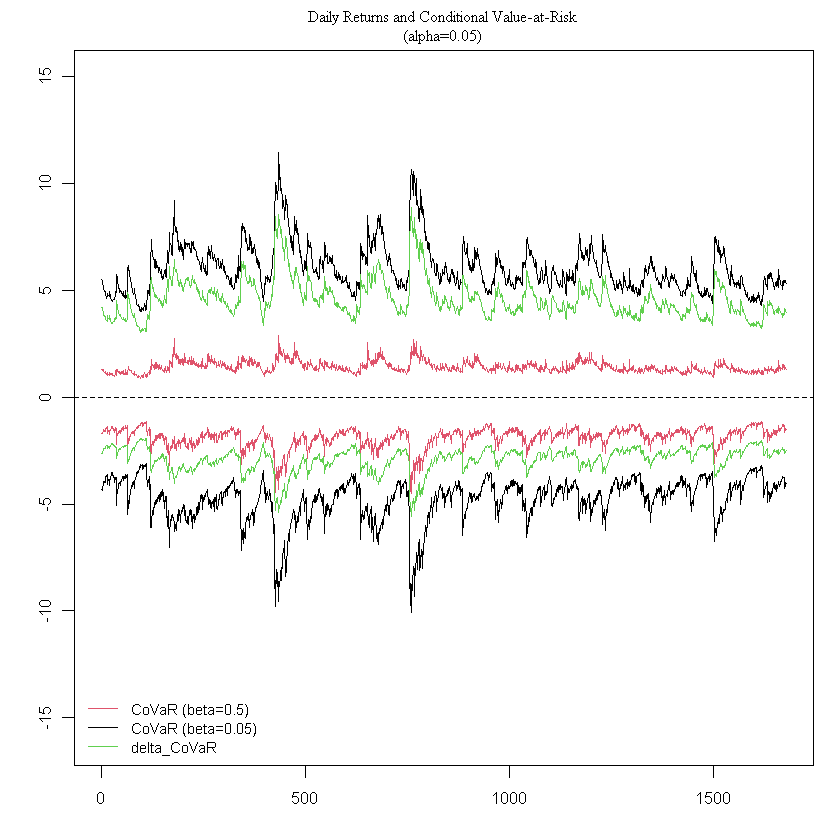

In [151]:
##plot the dynamic CoVaR and delta CoVaR
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$security)
tt <- seq(1:length(ts_df_1$security))
plot(tt,ts_df$security, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$security, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
lines(tt,CoVaR_095_005, lwd = 1, col = 1)
lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$security)

head(dynamic)